# 108-2 NLP Final Project: EmotionGIF 2020

Username: 

Password: 

[EmotionGIF 2020](https://sites.google.com/view/emotiongif-2020/home?authuser=0)

[CodaLab](https://competitions.codalab.org/competitions/24761#learn_the_details)




In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))
    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}

        </script>
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text,
    )

    return HTML(html)
hide_toggle()

In [2]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [67]:
import re
import math
import keras
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
tknzr = TweetTokenizer()
ps = PorterStemmer()
#negative = ["ain't",'aren',"aren't",'don',"don't",'not','couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
#nltk.download('stopwords')
#stopword = stopwords.words('english')
#stopword.extend(['️','.\n...','would',"i've","i'm","i'll","we're","they're","that's","he's","let's","y'all","i'd","there's"])
stopword = ['️']
punctuation = string.punctuation+'“’”...—…‼‘'

from emoji import UNICODE_EMOJI
hide_toggle()

In [68]:
with open('categories.json') as f:
    categories = json.load(f)

tweets = []
for line in open('train_gold.json', 'r'):
    tweets.append(json.loads(line))

test = []
for line in open('test_unlabeled.json', 'r'):
    test.append(json.loads(line))
    
dev = []
for line in open('dev_unlabeled.json','r'):
    dev.append(json.loads(line))

hide_toggle()

## Data Overview

In [31]:
print("There are {} categories: ".format(len(categories)))
print(categories)

There are 43 categories: 
['agree', 'applause', 'awww', 'dance', 'deal_with_it', 'do_not_want', 'eww', 'eye_roll', 'facepalm', 'fist_bump', 'good_luck', 'happy_dance', 'hearts', 'high_five', 'hug', 'idk', 'kiss', 'mic_drop', 'no', 'oh_snap', 'ok', 'omg', 'oops', 'please', 'popcorn', 'scared', 'seriously', 'shocked', 'shrug', 'sigh', 'slow_clap', 'smh', 'sorry', 'thank_you', 'thumbs_down', 'thumbs_up', 'want', 'win', 'wink', 'yawn', 'yes', 'yolo', 'you_got_this']


In [32]:
print("There are {} train tweets".format(len(tweets)))
print("There are {} dev tweets".format(len(dev)))
print("There are {} test tweets".format(len(test)))

There are 32000 train tweets
There are 4000 dev tweets
There are 4000 test tweets


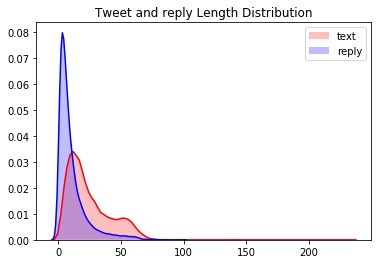

In [33]:
tweet_length = []
reply_length = []
for t in tweets:
    tweet_length.append(len(tknzr.tokenize(t['text'])))
    if t['reply'] != "":
        reply_length.append(len(tknzr.tokenize(t['reply'])))
sns.kdeplot(tweet_length,shade=True,color='r')
sns.kdeplot(reply_length,shade=True,color='b')
plt.legend(['text','reply'])
plt.title('Tweet and reply Length Distribution')
plt.show()
hide_toggle()

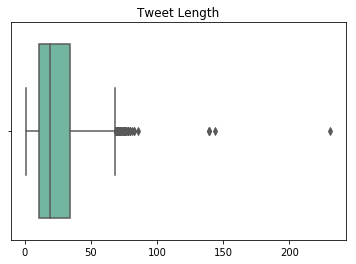

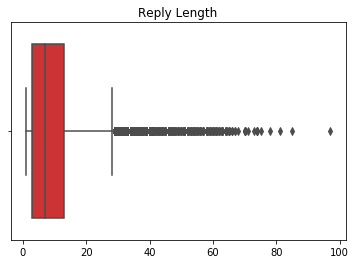

In [34]:
sns.boxplot(tweet_length,palette='Set2')
plt.title('Tweet Length')
plt.show()
sns.boxplot(reply_length,palette='Set1')
plt.title('Reply Length')
plt.show()

## EDA
### Explore categories of training set

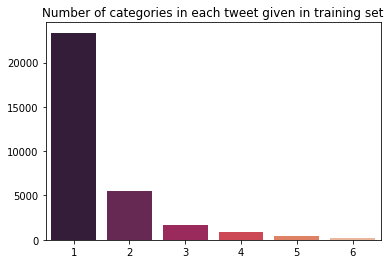

In [9]:
cat_len = Counter()
cat = Counter({c:0 for c in categories})
for t in tweets:
    cat_len.update([len(t['categories'])])
    cat.update(t['categories'])
    
sns.barplot(y=np.fromiter(cat_len.values(),dtype=int),x=np.fromiter(cat_len.keys(),dtype=int),palette="rocket")
plt.title('Number of categories in each tweet given in training set')
plt.show()
hide_toggle()

,categories,count
0,applause,3442
1,hug,3239
2,agree,2987
3,yes,2719
4,no,2185
5,seriously,2012
6,facepalm,2001
7,smh,1881
8,sigh,1768
9,shocked,1704


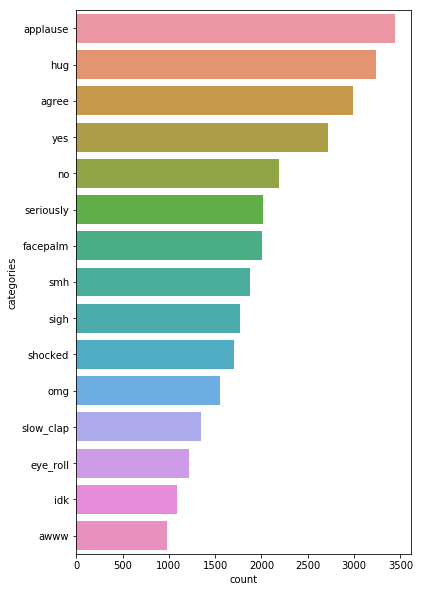

In [10]:
cat_temp = pd.DataFrame(cat.most_common(15))
cat_temp.columns = ['categories','count']
display(cat_temp.style.background_gradient(cmap='Blues'))
plt.subplots(figsize=(6,10))
sns.barplot(x='count',y='categories',data=cat_temp)
plt.show()
hide_toggle()

### Clean corpus

In [69]:
def rule(token):
    '''
    Remove tokens with
    x. stop words  Ex. the, we (Update: only rmv '️')
    2. punctuation Ex. !!
    3. numbers     Ex. 1kg
    4. hashtags    Ex. #NLP
    5. tags        Ex. @hannnnk
    6. hyper link  Ex. https://...
    '''
    return True if token not in stopword and \
                   token not in punctuation and \
                   not re.search('\d+', token) and \
                   not token.startswith('#') and \
                   not token.startswith('@') and \
                   not token.startswith('https:') \
                   else False

#### preprocessing
0. tokenize
1. lower     Ex. English → english
2. <s>stemming  Ex. needs(428) → need; loved(151) → love </s> (Since Embedding)
3. rmv by rule

In [70]:
def clean(tweet):
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"here's", "here is", tweet)
    tweet = re.sub(r"today's", "today is", tweet)
    tweet = re.sub(r"ain't", "are not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"how's", "how is", tweet)
    tweet = re.sub(r"thet've", "they have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"ya'll", "you all", tweet)
    tweet = re.sub(r"i'm", "i am", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"i've", "i have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"who-the-hell-even-knows-anymore", "who the hell even knows anymore", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"she's", "she is", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"shouldn't", "shoud not", tweet)  
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"you'd", "you had", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"no-excuse", "no excuse", tweet)
    tweet = re.sub(r"vote-by-mail", "vote by mail", tweet)
    tweet = re.sub(r"votesafe", "vote safe", tweet)
    tweet = re.sub(r"lmaoooo", "laugh my ass off", tweet)
    tweet = re.sub(r"we'd", "we had", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"he'd", "he had", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"hadn't", "had not", tweet)
    tweet = re.sub(r"diefrom", "die from", tweet)
    tweet = re.sub(r"dababy", "rapper", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"testing-based", "testing based", tweet)
    tweet = re.sub(r"that'll", "that will", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"cashapp", "cash app", tweet)
    tweet = re.sub(r"brexit-induced", "brexit induced", tweet)
    tweet = re.sub(r"president-hating", "president hating", tweet)
    tweet = re.sub(r"picked-over", "picked over", tweet)
    
    tweet = re.sub(r"what’s", "what is", tweet)
    tweet = re.sub(r"we’ll", "we will", tweet)
    tweet = re.sub(r"who’s", "who is", tweet)
    tweet = re.sub(r"here’s", "here is", tweet)
    tweet = re.sub(r"today’s", "today is", tweet)
    tweet = re.sub(r"ain’t", "are not", tweet)
    tweet = re.sub(r"we’ve", "we have", tweet)
    tweet = re.sub(r"how’s", "how is", tweet)
    tweet = re.sub(r"thet’ve", "they have", tweet)
    tweet = re.sub(r"it’ll", "it will", tweet)
    tweet = re.sub(r"ya’ll", "you all", tweet)
    tweet = re.sub(r"i’m", "i am", tweet)
    tweet = re.sub(r"don’t", "do not", tweet)
    tweet = re.sub(r"it’s", "it is", tweet)
    tweet = re.sub(r"you’re", "you are", tweet)
    tweet = re.sub(r"can’t", "cannot", tweet)
    tweet = re.sub(r"i’ve", "i have", tweet)
    tweet = re.sub(r"that’s", "that is", tweet)
    tweet = re.sub(r"we’re", "we are", tweet)
    tweet = re.sub(r"i’ll", "I will", tweet)
    tweet = re.sub(r"he’s", "he is", tweet)
    tweet = re.sub(r"let’s", "let us", tweet)
    tweet = re.sub(r"didn’t", "did not", tweet)
    tweet = re.sub(r"y’all", "you all", tweet)
    tweet = re.sub(r"doesn’t", "does not", tweet)
    tweet = re.sub(r"i’d", "I would", tweet)
    tweet = re.sub(r"there’s", "there is", tweet)
    tweet = re.sub(r"isn’t", "is not", tweet)
    tweet = re.sub(r"won’t", "will not", tweet)
    tweet = re.sub(r"they’re", "they are", tweet)
    tweet = re.sub(r"haven’t", "have not", tweet)
    tweet = re.sub(r"couldn’t", "could not", tweet)
    tweet = re.sub(r"she’s", "she is", tweet)
    tweet = re.sub(r"aren’t", "are not", tweet)
    tweet = re.sub(r"you’ve", "you have", tweet)
    tweet = re.sub(r"you’ll", "you will", tweet)
    tweet = re.sub(r"wouldn’t", "would not", tweet)
    tweet = re.sub(r"wasn’t", "was not", tweet)
    tweet = re.sub(r"shouldn’t", "shoud not", tweet)
    tweet = re.sub(r"they’ll", "they will", tweet)
    tweet = re.sub(r"weren’t", "were not", tweet)
    tweet = re.sub(r"you’d", "you had", tweet)
    tweet = re.sub(r"they’ve", "they have", tweet)
    tweet = re.sub(r"we’d", "we had", tweet)
    tweet = re.sub(r"he’ll", "he will", tweet)
    tweet = re.sub(r"he’d", "he had", tweet)
    tweet = re.sub(r"would’ve", "would have", tweet)
    tweet = re.sub(r"hadn’t", "had not", tweet)
    tweet = re.sub(r"hasn’t", "has not", tweet)
    tweet = re.sub(r"that’ll", "that will", tweet)
    tweet = re.sub(r"should’ve", "should have", tweet)
    
    return tweet
hide_toggle()

In [71]:
for t in tweets:
    t['text'] = clean(t['text'].lower())
    t['reply'] = clean(t['reply'].lower())
for t in dev:
    t['text'] = clean(t['text'].lower())
    t['reply'] = clean(t['reply'].lower())
for t in test:
    t['text'] = clean(t['text'].lower())
    t['reply'] = clean(t['reply'].lower())

In [72]:
tokens = Counter()
tokens2 = Counter()
for t in tweets:
    temp = [token.lower() for token in tknzr.tokenize(t['text']) if rule(token.lower())]
    temp2 = [token.lower() for token in tknzr.tokenize(t['reply']) if rule(token.lower())]

    tokens.update(temp)
    tokens2.update(temp2)
    t['text_clean'] = temp
    t['reply_clean'] = temp2

temp = pd.DataFrame(tokens.most_common(30))
temp.columns = ['tokens_main','count']
display(temp.style.background_gradient(cmap='Blues'))
temp2 = pd.DataFrame(tokens2.most_common(30))
temp2.columns = ['tokens_reply','count']
display(temp2.style.background_gradient(cmap='Reds'))

for t in dev:
    temp = [token.lower() for token in tknzr.tokenize(t['text']) if rule(token.lower())]
    temp2 = [token.lower() for token in tknzr.tokenize(t['reply']) if rule(token.lower())]

    t['text_clean'] = temp
    t['reply_clean'] = temp2
    
for t in test:
    temp = [token.lower() for token in tknzr.tokenize(t['text']) if rule(token.lower())]
    temp2 = [token.lower() for token in tknzr.tokenize(t['reply']) if rule(token.lower())]

    t['text_clean'] = temp
    t['reply_clean'] = temp2
hide_toggle()

,tokens_main,count
0,i,22433
1,the,18746
2,to,17174
3,a,14900
4,and,12369
5,is,12307
6,you,11667
7,of,9100
8,my,7712
9,in,7540


,tokens_reply,count
0,i,3618
1,you,3411
2,the,2588
3,to,2197
4,is,2025
5,a,1952
6,and,1819
7,it,1562
8,not,1340
9,that,1256


### Explore Emojis

In [11]:
def is_emoji(s):
    return s in UNICODE_EMOJI

#### First we explore emojis in tweet text

In [39]:
emoji = Counter()
for t in tokens:
    if len(t)==1:
        if ord(t)>122:
            emoji[t]=tokens[t]
emoji.most_common(20)

[('😂', 934),
 ('😭', 758),
 ('❤', 617),
 ('\u200d', 493),
 ('\U0001f97a', 429),
 ('🏽', 422),
 ('🏻', 313),
 ('👏', 307),
 ('🤣', 305),
 ('😊', 289),
 ('😔', 282),
 ('🤔', 280),
 ('♀', 249),
 ('🏾', 231),
 ('♂', 221),
 ('🏼', 206),
 ('🙏', 194),
 ('😩', 189),
 ('\U0001f974', 179),
 ('🤷', 175)]

In [41]:
for em in emoji.most_common(100):
    cat = Counter()
    for t in tweets:
        if em[0] in t['text_clean']:
            cat.update(t['categories'])
    print(em[0])
    temp = pd.DataFrame(cat.most_common(20))
    temp.columns = ['cat','count']
    display(temp.style.background_gradient(cmap='Blues'))

hide_toggle()

😂


,cat,count
0,applause,69
1,agree,62
2,seriously,51
3,smh,50
4,shocked,45
5,facepalm,45
6,yes,44
7,no,41
8,omg,40
9,idk,37


😭


,cat,count
0,hug,98
1,applause,48
2,shocked,32
3,agree,30
4,omg,27
5,yes,23
6,slow_clap,21
7,awww,21
8,dance,20
9,seriously,20


❤


,cat,count
0,hug,86
1,applause,66
2,awww,35
3,yes,30
4,dance,29
5,thank_you,29
6,hearts,27
7,slow_clap,26
8,agree,22
9,please,21


‍


,cat,count
0,applause,48
1,facepalm,44
2,agree,43
3,seriously,42
4,smh,35
5,sigh,31
6,yes,29
7,no,29
8,shocked,27
9,omg,21


🥺


,cat,count
0,hug,120
1,awww,32
2,applause,27
3,yes,24
4,agree,20
5,you_got_this,17
6,sigh,16
7,dance,12
8,shocked,12
9,slow_clap,11


🏽


,cat,count
0,applause,26
1,shocked,17
2,agree,17
3,yes,13
4,slow_clap,12
5,oh_snap,12
6,sigh,10
7,omg,10
8,no,9
9,awww,8


🏻


,cat,count
0,hug,30
1,applause,29
2,agree,18
3,no,11
4,sigh,11
5,smh,10
6,dance,10
7,yes,9
8,facepalm,9
9,thank_you,9


👏


,cat,count
0,applause,13
1,slow_clap,7
2,thank_you,6
3,high_five,5
4,agree,4
5,smh,3
6,hug,3
7,seriously,3
8,happy_dance,3
9,awww,2


🤣


,cat,count
0,shocked,24
1,applause,22
2,omg,18
3,facepalm,18
4,smh,17
5,no,16
6,agree,16
7,seriously,14
8,yes,13
9,sigh,13


😊


,cat,count
0,yes,51
1,happy_dance,49
2,dance,45
3,applause,34
4,hug,17
5,omg,16
6,awww,13
7,slow_clap,12
8,win,11
9,thank_you,11


😔


,cat,count
0,hug,144
1,you_got_this,29
2,sigh,15
3,shocked,12
4,good_luck,11
5,applause,10
6,smh,9
7,facepalm,9
8,awww,8
9,omg,6


🤔


,cat,count
0,agree,36
1,yes,34
2,no,29
3,smh,27
4,seriously,27
5,sigh,25
6,facepalm,21
7,shocked,17
8,omg,15
9,shrug,15


♀


,cat,count
0,applause,23
1,agree,22
2,facepalm,21
3,seriously,20
4,shocked,19
5,yes,16
6,smh,16
7,no,15
8,sigh,13
9,dance,12


🏾


,cat,count
0,applause,34
1,slow_clap,15
2,dance,13
3,shocked,12
4,sigh,12
5,no,10
6,facepalm,10
7,yes,10
8,seriously,10
9,smh,9


♂


,cat,count
0,facepalm,24
1,agree,23
2,seriously,22
3,smh,18
4,sigh,18
5,applause,18
6,no,15
7,yes,14
8,omg,11
9,high_five,10


🏼


,cat,count
0,applause,25
1,agree,20
2,yes,15
3,omg,11
4,shocked,10
5,good_luck,10
6,seriously,9
7,dance,9
8,facepalm,8
9,happy_dance,7


🙏


,cat,count
0,applause,40
1,yes,16
2,hug,15
3,agree,14
4,slow_clap,13
5,you_got_this,11
6,dance,11
7,good_luck,11
8,high_five,9
9,thank_you,8


😩


,cat,count
0,agree,16
1,smh,13
2,seriously,13
3,no,12
4,shocked,12
5,omg,11
6,facepalm,11
7,awww,10
8,applause,9
9,hug,9


🥴


,cat,count
0,smh,15
1,shocked,15
2,agree,14
3,seriously,14
4,sigh,13
5,oh_snap,12
6,facepalm,11
7,no,11
8,applause,9
9,idk,9


🤷


,cat,count
0,agree,24
1,seriously,22
2,facepalm,22
3,applause,20
4,smh,17
5,sigh,17
6,shocked,14
7,oh_snap,12
8,yes,11
9,hug,11


🔥


,cat,count
0,dance,15
1,yes,14
2,applause,12
3,agree,10
4,happy_dance,9
5,slow_clap,7
6,seriously,6
7,facepalm,6
8,sigh,5
9,win,5


😍


,cat,count
0,awww,17
1,applause,16
2,dance,12
3,hug,8
4,agree,7
5,thank_you,6
6,hearts,6
7,yes,6
8,oops,5
9,shocked,5


👀


,cat,count
0,yes,22
1,agree,14
2,applause,12
3,no,11
4,shocked,9
5,smh,8
6,happy_dance,8
7,omg,7
8,scared,7
9,seriously,7


🥰


,cat,count
0,awww,15
1,applause,14
2,agree,10
3,yes,10
4,hug,9
5,happy_dance,8
6,dance,8
7,shocked,7
8,good_luck,7
9,slow_clap,7


🤦


,cat,count
0,facepalm,21
1,smh,17
2,seriously,17
3,sigh,14
4,shocked,12
5,agree,9
6,oops,8
7,no,8
8,omg,8
9,applause,8


💙


,cat,count
0,applause,20
1,hug,12
2,please,9
3,slow_clap,7
4,yes,7
5,agree,6
6,dance,6
7,happy_dance,5
8,hearts,5
9,thumbs_up,3


😬


,cat,count
0,scared,7
1,yes,7
2,applause,6
3,oops,6
4,shocked,6
5,omg,6
6,hug,6
7,agree,6
8,facepalm,4
9,smh,4


🇺


,cat,count
0,applause,18
1,thank_you,10
2,yes,9
3,thumbs_up,7
4,agree,7
5,ok,6
6,slow_clap,6
7,seriously,4
8,facepalm,4
9,sigh,4


🙄


,cat,count
0,seriously,13
1,applause,12
2,facepalm,12
3,sigh,10
4,omg,9
5,smh,9
6,eye_roll,7
7,oops,7
8,no,6
9,shocked,6


🙃


,cat,count
0,hug,26
1,shocked,10
2,smh,10
3,omg,9
4,sigh,8
5,you_got_this,7
6,yes,7
7,facepalm,7
8,agree,7
9,applause,6


🇸


,cat,count
0,applause,18
1,thank_you,10
2,yes,8
3,thumbs_up,7
4,agree,7
5,slow_clap,6
6,ok,5
7,seriously,4
8,facepalm,4
9,sigh,4


💜


,cat,count
0,hug,35
1,kiss,7
2,hearts,6
3,dance,6
4,awww,5
5,thank_you,5
6,applause,5
7,you_got_this,4
8,happy_dance,3
9,agree,3


👇


,cat,count
0,no,8
1,applause,7
2,dance,5
3,eye_roll,5
4,thumbs_up,4
5,seriously,4
6,yawn,4
7,sigh,4
8,yes,4
9,ok,3


✅


,cat,count
0,applause,11
1,thank_you,9
2,good_luck,6
3,yes,5
4,happy_dance,5
5,please,5
6,agree,4
7,dance,4
8,ok,4
9,sigh,3


👍


,cat,count
0,applause,24
1,thank_you,10
2,slow_clap,10
3,yes,9
4,thumbs_up,7
5,hug,6
6,win,6
7,high_five,5
8,good_luck,5
9,ok,4


😘


,cat,count
0,awww,9
1,dance,8
2,hug,8
3,applause,8
4,yes,7
5,kiss,6
6,agree,6
7,hearts,6
8,ok,5
9,please,4


💕


,cat,count
0,awww,12
1,hug,12
2,thank_you,12
3,applause,10
4,yes,7
5,dance,7
6,slow_clap,7
7,hearts,6
8,wink,6
9,you_got_this,6


✨


,cat,count
0,hug,10
1,applause,10
2,awww,9
3,happy_dance,7
4,thank_you,7
5,hearts,6
6,yes,6
7,slow_clap,5
8,you_got_this,5
9,good_luck,5


🙌


,cat,count
0,applause,22
1,slow_clap,12
2,dance,11
3,happy_dance,11
4,yes,9
5,you_got_this,5
6,awww,4
7,high_five,4
8,yawn,3
9,facepalm,3


😁


,cat,count
0,applause,16
1,yes,15
2,slow_clap,8
3,agree,8
4,dance,6
5,seriously,5
6,omg,5
7,no,5
8,fist_bump,5
9,oh_snap,5


😅


,cat,count
0,smh,10
1,applause,9
2,no,8
3,agree,7
4,yes,7
5,sigh,7
6,omg,6
7,happy_dance,6
8,shocked,6
9,seriously,6


😳


,cat,count
0,shocked,10
1,omg,9
2,sigh,9
3,applause,8
4,seriously,7
5,scared,6
6,smh,6
7,no,5
8,oh_snap,4
9,ok,4


♥


,cat,count
0,dance,11
1,applause,9
2,awww,8
3,kiss,5
4,hug,5
5,happy_dance,4
6,please,4
7,wink,3
8,hearts,3
9,facepalm,2


•


,cat,count
0,eww,3
1,awww,3
2,wink,2
3,deal_with_it,2
4,smh,2
5,applause,2
6,yes,1
7,agree,1
8,hearts,1
9,thank_you,1


👉


,cat,count
0,hug,27
1,high_five,4
2,applause,4
3,you_got_this,4
4,shocked,4
5,agree,4
6,yes,3
7,eye_roll,3
8,sigh,3
9,dance,3


💎


,cat,count
0,applause,10
1,dance,9
2,agree,5
3,shrug,4
4,happy_dance,4
5,awww,3
6,mic_drop,3
7,idk,3
8,slow_clap,3
9,smh,3


🥳


,cat,count
0,applause,15
1,dance,11
2,thank_you,7
3,shocked,5
4,hug,4
5,slow_clap,3
6,smh,3
7,hearts,2
8,eye_roll,2
9,sigh,2


🙋


,cat,count
0,high_five,8
1,no,7
2,yes,7
3,agree,6
4,applause,5
5,dance,2
6,happy_dance,2
7,scared,2
8,hug,1
9,eww,1


👈


,cat,count
0,hug,27
1,you_got_this,4
2,shocked,4
3,no,3
4,yes,3
5,eye_roll,3
6,high_five,3
7,applause,3
8,sigh,3
9,dance,3


🎉


,cat,count
0,thank_you,11
1,applause,11
2,dance,7
3,awww,4
4,high_five,3
5,yes,3
6,hug,2
7,agree,2
8,slow_clap,2
9,omg,2


🤗


,cat,count
0,hug,21
1,omg,4
2,applause,4
3,good_luck,4
4,dance,3
5,happy_dance,3
6,you_got_this,3
7,shocked,2
8,awww,2
9,slow_clap,2


💔


,cat,count
0,hug,37
1,ok,5
2,sigh,5
3,yes,4
4,facepalm,4
5,please,3
6,you_got_this,3
7,awww,3
8,wink,3
9,no,2


😫


,cat,count
0,sigh,6
1,shocked,6
2,hug,5
3,seriously,5
4,facepalm,5
5,omg,5
6,eww,4
7,applause,4
8,oops,4
9,eye_roll,4


☹


,cat,count
0,hug,29
1,sigh,8
2,seriously,5
3,agree,5
4,smh,5
5,no,3
6,facepalm,3
7,you_got_this,3
8,awww,2
9,eye_roll,2


→


,cat,count
0,no,6
1,deal_with_it,2
2,thumbs_down,2
3,yes,2
4,eye_roll,2
5,seriously,2
6,smh,2
7,agree,1
8,sigh,1
9,do_not_want,1


✌


,cat,count
0,applause,9
1,hug,8
2,thank_you,7
3,sigh,4
4,facepalm,4
5,omg,4
6,yes,4
7,smh,3
8,no,3
9,oh_snap,3


😌


,cat,count
0,applause,11
1,slow_clap,10
2,yes,6
3,smh,4
4,eww,4
5,agree,4
6,shocked,3
7,wink,3
8,dance,3
9,awww,3


😎


,cat,count
0,applause,14
1,yes,8
2,dance,6
3,happy_dance,6
4,agree,5
5,high_five,4
6,good_luck,3
7,you_got_this,3
8,slow_clap,3
9,sigh,3


💀


,cat,count
0,shocked,8
1,oops,7
2,oh_snap,7
3,omg,6
4,facepalm,6
5,applause,5
6,ok,5
7,scared,5
8,idk,4
9,sigh,4


😒


,cat,count
0,seriously,9
1,sigh,8
2,facepalm,7
3,smh,7
4,no,6
5,eye_roll,6
6,hug,4
7,agree,3
8,dance,3
9,omg,3


😢


,cat,count
0,hug,19
1,applause,7
2,you_got_this,4
3,awww,4
4,shocked,3
5,smh,3
6,eye_roll,2
7,good_luck,2
8,agree,2
9,yes,2


💛


,cat,count
0,hug,10
1,applause,5
2,yes,5
3,awww,4
4,thank_you,4
5,slow_clap,3
6,good_luck,3
7,you_got_this,3
8,high_five,2
9,happy_dance,2


🏿


,cat,count
0,applause,4
1,eye_roll,4
2,agree,2
3,seriously,2
4,sigh,2
5,facepalm,2
6,scared,1
7,no,1
8,awww,1
9,slow_clap,1


🤯


,cat,count
0,yes,8
1,smh,6
2,sigh,6
3,shrug,5
4,ok,4
5,seriously,4
6,idk,4
7,eye_roll,4
8,facepalm,3
9,agree,3


☺


,cat,count
0,yes,5
1,agree,4
2,applause,4
3,omg,4
4,hug,3
5,awww,3
6,shocked,3
7,facepalm,3
8,smh,3
9,hearts,2


💖


,cat,count
0,thank_you,10
1,hug,6
2,applause,4
3,awww,4
4,agree,3
5,yes,3
6,kiss,2
7,smh,2
8,sigh,2
9,please,2


😉


,cat,count
0,agree,7
1,applause,5
2,yes,4
3,dance,3
4,hug,3
5,thumbs_up,3
6,good_luck,3
7,you_got_this,3
8,awww,2
9,want,2


⬇


,cat,count
0,no,7
1,shrug,5
2,idk,4
3,dance,3
4,smh,3
5,facepalm,3
6,seriously,2
7,happy_dance,2
8,do_not_want,2
9,sigh,2


💰


,cat,count
0,good_luck,11
1,applause,8
2,please,7
3,thank_you,5
4,slow_clap,4
5,you_got_this,3
6,dance,3
7,awww,3
8,yes,3
9,agree,2


💯


,cat,count
0,applause,14
1,slow_clap,6
2,dance,5
3,agree,4
4,thank_you,3
5,awww,3
6,yes,3
7,seriously,2
8,want,2
9,sigh,2


🙂


,cat,count
0,hug,6
1,yes,5
2,thank_you,4
3,shocked,4
4,agree,4
5,popcorn,3
6,awww,3
7,no,3
8,oh_snap,2
9,oops,2


🚨


,cat,count
0,applause,5
1,agree,4
2,no,3
3,thumbs_up,2
4,please,2
5,seriously,2
6,slow_clap,2
7,shocked,2
8,eye_roll,2
9,dance,2


😏


,cat,count
0,yes,9
1,agree,6
2,applause,6
3,awww,4
4,slow_clap,3
5,eww,3
6,happy_dance,3
7,no,2
8,seriously,2
9,facepalm,2


£


,cat,count
0,applause,9
1,slow_clap,5
2,seriously,5
3,facepalm,4
4,sigh,3
5,agree,3
6,no,2
7,thank_you,2
8,omg,2
9,scared,2


😐


,cat,count
0,hug,6
1,shocked,5
2,agree,5
3,idk,4
4,oh_snap,4
5,oops,3
6,omg,3
7,eww,3
8,facepalm,3
9,yes,3


💚


,cat,count
0,applause,4
1,thank_you,3
2,dance,3
3,happy_dance,3
4,hug,2
5,good_luck,2
6,you_got_this,2
7,awww,2
8,no,2
9,hearts,2


–


,cat,count
0,omg,5
1,sigh,4
2,facepalm,4
3,smh,4
4,yes,4
5,seriously,4
6,applause,4
7,eww,3
8,shocked,3
9,eye_roll,3


🤪


,cat,count
0,hug,5
1,applause,5
2,shocked,4
3,omg,4
4,wink,4
5,agree,4
6,seriously,3
7,awww,3
8,yes,3
9,happy_dance,3


😈


,cat,count
0,shocked,9
1,applause,5
2,omg,5
3,agree,4
4,slow_clap,3
5,facepalm,3
6,ok,3
7,yes,2
8,want,2
9,popcorn,2


🖤


,cat,count
0,hug,8
1,awww,6
2,yes,5
3,agree,5
4,no,2
5,good_luck,2
6,you_got_this,2
7,applause,2
8,ok,1
9,please,1


🤩


,cat,count
0,yes,6
1,applause,4
2,scared,3
3,omg,3
4,facepalm,3
5,dance,3
6,popcorn,2
7,agree,2
8,oops,2
9,eww,2


💗


,cat,count
0,hug,13
1,thank_you,6
2,applause,3
3,agree,3
4,good_luck,3
5,you_got_this,2
6,eye_roll,2
7,win,2
8,ok,2
9,high_five,2


💪


,cat,count
0,applause,15
1,slow_clap,7
2,agree,4
3,good_luck,3
4,you_got_this,3
5,hug,3
6,yes,3
7,popcorn,2
8,dance,2
9,happy_dance,2


🤞


,cat,count
0,good_luck,8
1,applause,5
2,yes,5
3,you_got_this,5
4,agree,3
5,slow_clap,3
6,please,3
7,hug,2
8,shocked,2
9,dance,2


😞


,cat,count
0,hug,23
1,no,2
2,eye_roll,2
3,sigh,2
4,smh,2
5,sorry,2
6,slow_clap,2
7,agree,1
8,yes,1
9,ok,1


🤨


,cat,count
0,agree,15
1,yes,12
2,seriously,8
3,smh,3
4,sigh,3
5,idk,3
6,facepalm,3
7,oops,3
8,eww,2
9,shrug,2


💃


,cat,count
0,dance,5
1,agree,3
2,eww,2
3,yes,1
4,facepalm,1
5,popcorn,1
6,yawn,1
7,you_got_this,1
8,thumbs_up,1
9,thank_you,1


😴


,cat,count
0,smh,5
1,applause,4
2,facepalm,3
3,sigh,2
4,eye_roll,2
5,yes,2
6,hug,2
7,shrug,1
8,oops,1
9,idk,1


🧐


,cat,count
0,yes,6
1,smh,5
2,agree,4
3,oops,3
4,seriously,3
5,facepalm,3
6,omg,3
7,oh_snap,3
8,no,3
9,popcorn,3


😋


,cat,count
0,applause,6
1,yes,5
2,slow_clap,4
3,smh,2
4,shrug,2
5,seriously,2
6,facepalm,2
7,eye_roll,2
8,oops,2
9,thank_you,1


🤧


,cat,count
0,shocked,4
1,dance,3
2,hug,3
3,facepalm,3
4,no,2
5,scared,2
6,applause,2
7,agree,2
8,seriously,2
9,smh,2


👌


,cat,count
0,agree,9
1,applause,7
2,yes,4
3,shocked,3
4,wink,2
5,awww,2
6,good_luck,2
7,eye_roll,2
8,oh_snap,2
9,omg,2


🤤


,cat,count
0,yes,5
1,seriously,5
2,omg,4
3,facepalm,4
4,eww,4
5,applause,3
6,slow_clap,2
7,smh,2
8,agree,2
9,wink,2


😣


,cat,count
0,hug,10
1,eye_roll,5
2,smh,4
3,shocked,4
4,facepalm,4
5,seriously,3
6,sigh,2
7,idk,2
8,agree,2
9,sorry,2


😤


,cat,count
0,hug,6
1,applause,6
2,shocked,4
3,yes,3
4,slow_clap,3
5,dance,2
6,win,2
7,awww,2
8,want,2
9,popcorn,2


🤮


,cat,count
0,eww,10
1,facepalm,5
2,shocked,4
3,seriously,3
4,smh,3
5,sigh,3
6,idk,3
7,omg,3
8,applause,2
9,oops,2


🤢


,cat,count
0,eww,7
1,omg,5
2,hug,4
3,facepalm,4
4,smh,3
5,oh_snap,3
6,shocked,3
7,seriously,3
8,awww,2
9,oops,2


🍆


,cat,count
0,awww,2
1,high_five,2
2,yes,2
3,fist_bump,2
4,smh,2
5,oh_snap,2
6,dance,1
7,eww,1
8,ok,1
9,shrug,1


🐑


,cat,count
0,slow_clap,1
1,applause,1
2,ok,1


😪


,cat,count
0,agree,6
1,yes,4
2,hug,4
3,no,3
4,shocked,3
5,you_got_this,3
6,oh_snap,3
7,applause,3
8,sigh,2
9,ok,2


#### Then emojis in replies

In [42]:
emoji2 = Counter()
for t in tokens2:
    if len(t)==1:
        if ord(t)>122:
            emoji2[t]=tokens2[t]
emoji2.most_common(20)

[('😂', 687),
 ('❤', 525),
 ('🤣', 361),
 ('🙏', 219),
 ('😭', 218),
 ('👏', 179),
 ('\U0001f97a', 179),
 ('🏻', 164),
 ('\u200d', 147),
 ('💜', 145),
 ('😍', 129),
 ('👍', 126),
 ('🤗', 121),
 ('🏼', 117),
 ('💕', 112),
 ('🏾', 109),
 ('💖', 104),
 ('😘', 97),
 ('💙', 92),
 ('🏽', 88)]

In [43]:
for em in emoji2.most_common(100):
    cat = Counter()
    for t in tweets:
        if em[0] in t['reply_clean']:
            cat.update(t['categories'])
    print(em[0])
    temp = pd.DataFrame(cat.most_common(20))
    temp.columns = ['cat','count']
    display(temp.style.background_gradient(cmap='Blues'))
hide_toggle()

😂


,cat,count
0,applause,44
1,smh,41
2,seriously,33
3,shocked,33
4,facepalm,32
5,omg,31
6,sigh,27
7,agree,27
8,no,25
9,idk,23


❤


,cat,count
0,hug,142
1,applause,26
2,thank_you,23
3,hearts,20
4,awww,19
5,yes,16
6,please,15
7,happy_dance,14
8,you_got_this,14
9,dance,12


🤣


,cat,count
0,no,17
1,oh_snap,16
2,smh,16
3,facepalm,16
4,applause,15
5,seriously,15
6,shocked,14
7,popcorn,11
8,agree,10
9,idk,9


🙏


,cat,count
0,hug,30
1,please,25
2,thank_you,17
3,agree,13
4,applause,11
5,yes,10
6,awww,8
7,good_luck,7
8,dance,5
9,hearts,4


😭


,cat,count
0,hug,23
1,please,16
2,sigh,14
3,oh_snap,10
4,applause,9
5,yes,8
6,shocked,8
7,ok,8
8,no,8
9,awww,7


👏


,cat,count
0,applause,46
1,slow_clap,17
2,agree,9
3,dance,6
4,yes,5
5,thank_you,5
6,win,3
7,thumbs_up,3
8,happy_dance,2
9,high_five,2


🥺


,cat,count
0,hug,82
1,awww,11
2,please,9
3,you_got_this,7
4,thank_you,6
5,want,6
6,hearts,5
7,omg,4
8,no,3
9,yes,3


🏻


,cat,count
0,applause,16
1,yes,11
2,agree,10
3,facepalm,7
4,slow_clap,6
5,sigh,6
6,thank_you,6
7,you_got_this,6
8,please,5
9,hug,5


‍


,cat,count
0,facepalm,15
1,seriously,13
2,smh,11
3,idk,11
4,sigh,11
5,agree,10
6,shrug,10
7,eye_roll,9
8,omg,7
9,no,6


💜


,cat,count
0,hug,58
1,you_got_this,8
2,applause,5
3,hearts,3
4,thank_you,3
5,slow_clap,2
6,awww,2
7,good_luck,2
8,yes,2
9,dance,1


😍


,cat,count
0,happy_dance,15
1,yes,12
2,applause,12
3,awww,10
4,dance,10
5,hug,7
6,slow_clap,5
7,omg,5
8,hearts,4
9,please,4


👍


,cat,count
0,agree,25
1,applause,18
2,yes,16
3,thumbs_up,11
4,thank_you,9
5,you_got_this,8
6,slow_clap,7
7,hug,6
8,win,5
9,happy_dance,5


🤗


,cat,count
0,hug,46
1,dance,6
2,hearts,5
3,awww,5
4,please,4
5,you_got_this,4
6,applause,4
7,high_five,2
8,happy_dance,2
9,thumbs_up,2


🏼


,cat,count
0,applause,10
1,please,8
2,agree,8
3,yes,8
4,slow_clap,7
5,hug,7
6,seriously,5
7,thank_you,5
8,awww,4
9,scared,3


💕


,cat,count
0,hug,39
1,dance,6
2,awww,5
3,happy_dance,5
4,applause,4
5,you_got_this,3
6,kiss,3
7,hearts,3
8,high_five,3
9,thank_you,3


🏾


,cat,count
0,applause,14
1,hug,6
2,slow_clap,6
3,seriously,6
4,agree,5
5,shocked,5
6,no,4
7,facepalm,4
8,shrug,4
9,thank_you,3


💖


,cat,count
0,hug,25
1,thank_you,6
2,applause,5
3,hearts,4
4,yes,3
5,happy_dance,3
6,win,2
7,please,2
8,dance,2
9,you_got_this,1


😘


,cat,count
0,hug,20
1,thank_you,10
2,awww,5
3,hearts,4
4,kiss,3
5,happy_dance,3
6,yes,2
7,wink,2
8,good_luck,2
9,slow_clap,2


💙


,cat,count
0,hug,31
1,thank_you,7
2,yes,6
3,you_got_this,4
4,hearts,3
5,agree,2
6,kiss,2
7,applause,2
8,dance,2
9,good_luck,2


🏽


,cat,count
0,applause,12
1,dance,7
2,agree,5
3,yes,4
4,slow_clap,4
5,happy_dance,3
6,shocked,3
7,omg,3
8,idk,3
9,smh,3


♀


,cat,count
0,seriously,9
1,facepalm,8
2,eye_roll,6
3,agree,6
4,idk,6
5,shrug,6
6,omg,5
7,sigh,5
8,smh,4
9,no,4


♥


,cat,count
0,hug,18
1,yes,5
2,hearts,4
3,kiss,3
4,you_got_this,3
5,awww,2
6,happy_dance,2
7,applause,2
8,wink,2
9,agree,2


💞


,cat,count
0,hug,13
1,thank_you,4
2,applause,4
3,happy_dance,2
4,slow_clap,2
5,dance,1
6,eye_roll,1
7,yes,1


😊


,cat,count
0,hug,13
1,awww,7
2,yes,6
3,thank_you,6
4,hearts,6
5,happy_dance,5
6,slow_clap,4
7,applause,4
8,ok,4
9,wink,3


🥰


,cat,count
0,hug,17
1,awww,12
2,applause,5
3,hearts,4
4,thank_you,4
5,slow_clap,3
6,yes,2
7,agree,2
8,please,2
9,dance,2


🙌


,cat,count
0,applause,8
1,agree,5
2,slow_clap,4
3,dance,3
4,thank_you,3
5,yes,3
6,hearts,2
7,thumbs_up,2
8,wink,2
9,facepalm,2


😁


,cat,count
0,yes,7
1,applause,6
2,please,5
3,happy_dance,5
4,agree,4
5,hug,4
6,oops,4
7,awww,3
8,dance,3
9,win,3


🔥


,cat,count
0,dance,12
1,applause,7
2,slow_clap,5
3,sigh,4
4,smh,3
5,seriously,3
6,facepalm,3
7,agree,2
8,yes,1
9,happy_dance,1


💗


,cat,count
0,hug,21
1,hearts,3
2,awww,2
3,you_got_this,2
4,kiss,2
5,happy_dance,2
6,thank_you,2
7,high_five,1
8,ok,1
9,thumbs_up,1


🇺


,cat,count
0,yes,5
1,agree,5
2,deal_with_it,3
3,ok,3
4,thank_you,3
5,applause,3
6,thumbs_up,2
7,facepalm,2
8,wink,1
9,mic_drop,1


😉


,cat,count
0,wink,8
1,ok,4
2,hug,4
3,yes,4
4,popcorn,3
5,hearts,3
6,agree,3
7,facepalm,2
8,happy_dance,2
9,awww,2


👀


,cat,count
0,shocked,6
1,omg,5
2,oh_snap,4
3,popcorn,4
4,facepalm,4
5,sigh,4
6,smh,4
7,seriously,3
8,agree,3
9,eye_roll,3


🇸


,cat,count
0,yes,5
1,agree,4
2,deal_with_it,3
3,ok,3
4,thumbs_up,2
5,thank_you,2
6,applause,2
7,wink,1
8,mic_drop,1
9,win,1


🤷


,cat,count
0,idk,11
1,shrug,11
2,facepalm,6
3,agree,6
4,seriously,5
5,smh,4
6,no,4
7,oops,4
8,eye_roll,3
9,scared,3


🤔


,cat,count
0,idk,8
1,agree,5
2,shocked,5
3,omg,5
4,applause,4
5,oops,4
6,eye_roll,4
7,smh,4
8,seriously,4
9,facepalm,4


💛


,cat,count
0,hug,15
1,yes,3
2,hearts,2
3,you_got_this,2
4,fist_bump,1
5,kiss,1
6,dance,1
7,happy_dance,1
8,agree,1
9,shocked,1


🤦


,cat,count
0,facepalm,12
1,seriously,11
2,smh,10
3,sigh,10
4,eye_roll,6
5,omg,4
6,yawn,3
7,thank_you,3
8,shocked,3
9,no,2


♂


,cat,count
0,smh,7
1,facepalm,7
2,sigh,6
3,idk,5
4,shrug,4
5,seriously,4
6,eye_roll,3
7,shocked,3
8,no,2
9,applause,2


💓


,cat,count
0,hug,10
1,dance,3
2,thank_you,3
3,hearts,3
4,happy_dance,2
5,you_got_this,2
6,yes,1
7,applause,1
8,sorry,1


🖤


,cat,count
0,hug,4
1,thank_you,4
2,awww,3
3,dance,2
4,thumbs_up,2
5,you_got_this,1
6,oh_snap,1
7,hearts,1
8,kiss,1
9,agree,1


💪


,cat,count
0,you_got_this,5
1,hug,5
2,yes,4
3,high_five,4
4,applause,3
5,good_luck,3
6,dance,2
7,agree,2
8,thank_you,1
9,hearts,1


🙄


,cat,count
0,eye_roll,10
1,smh,6
2,sigh,6
3,facepalm,5
4,no,3
5,seriously,3
6,idk,3
7,shocked,3
8,omg,2
9,sorry,2


💯


,cat,count
0,agree,9
1,yes,4
2,slow_clap,4
3,applause,4
4,high_five,3
5,thumbs_up,3
6,oh_snap,3
7,good_luck,2
8,hearts,2
9,dance,2


☺


,cat,count
0,awww,7
1,hug,5
2,thumbs_up,5
3,yes,3
4,hearts,2
5,agree,2
6,ok,2
7,you_got_this,2
8,oops,1
9,applause,1


💃


,cat,count
0,dance,8
1,happy_dance,6
2,applause,2
3,smh,1
4,seriously,1
5,facepalm,1
6,sigh,1
7,thumbs_up,1


😅


,cat,count
0,scared,4
1,oops,4
2,ok,3
3,you_got_this,3
4,dance,2
5,please,2
6,agree,2
7,thumbs_up,2
8,deal_with_it,2
9,sigh,1


🎉


,cat,count
0,applause,13
1,dance,7
2,happy_dance,4
3,slow_clap,3
4,yes,2
5,hug,2
6,thumbs_up,2
7,win,1
8,you_got_this,1
9,oops,1


😎


,cat,count
0,yes,6
1,agree,5
2,dance,3
3,oh_snap,3
4,ok,3
5,high_five,3
6,deal_with_it,2
7,want,2
8,thumbs_up,2
9,win,2


😔


,cat,count
0,hug,13
1,awww,3
2,sigh,2
3,you_got_this,2
4,thank_you,1
5,hearts,1
6,idk,1
7,good_luck,1
8,sorry,1
9,agree,1


💚


,cat,count
0,hug,13
1,thank_you,3
2,dance,2
3,yes,1
4,high_five,1
5,please,1
6,happy_dance,1
7,wink,1
8,awww,1
9,mic_drop,1


💔


,cat,count
0,hug,5
1,sigh,3
2,shocked,2
3,omg,2
4,dance,1
5,seriously,1
6,smh,1
7,facepalm,1
8,eww,1
9,hearts,1


✨


,cat,count
0,hug,9
1,applause,5
2,awww,3
3,dance,2
4,happy_dance,2
5,slow_clap,2
6,kiss,1
7,thumbs_up,1
8,hearts,1
9,popcorn,1


🇧


,cat,count
0,applause,4
1,thank_you,2
2,yes,2
3,popcorn,1
4,oh_snap,1
5,shocked,1
6,scared,1
7,seriously,1
8,agree,1


😢


,cat,count
0,hug,13
1,dance,2
2,slow_clap,1
3,applause,1
4,please,1
5,no,1
6,omg,1
7,sigh,1
8,want,1
9,shrug,1


😳


,cat,count
0,shocked,6
1,omg,5
2,scared,4
3,facepalm,2
4,oh_snap,2
5,ok,2
6,applause,2
7,seriously,1
8,hug,1
9,smh,1


😀


,cat,count
0,applause,4
1,dance,3
2,thank_you,2
3,slow_clap,2
4,high_five,2
5,please,2
6,happy_dance,2
7,seriously,1
8,thumbs_up,1
9,hug,1


😆


,cat,count
0,slow_clap,4
1,smh,4
2,applause,4
3,good_luck,3
4,eye_roll,2
5,facepalm,2
6,you_got_this,2
7,do_not_want,1
8,oh_snap,1
9,seriously,1


😩


,cat,count
0,smh,3
1,sigh,3
2,facepalm,3
3,seriously,2
4,hug,2
5,no,1
6,shocked,1
7,want,1
8,eye_roll,1
9,deal_with_it,1


😌


,cat,count
0,applause,4
1,awww,3
2,popcorn,2
3,yes,2
4,hug,2
5,want,1
6,good_luck,1
7,win,1
8,please,1
9,slow_clap,1


👇


,cat,count
0,agree,3
1,scared,2
2,yes,2
3,happy_dance,2
4,oops,1
5,sigh,1
6,applause,1
7,awww,1
8,thank_you,1
9,eww,1


😒


,cat,count
0,seriously,5
1,eye_roll,4
2,smh,3
3,sigh,3
4,facepalm,3
5,eww,3
6,idk,3
7,shrug,2
8,agree,2
9,yes,2


😬


,cat,count
0,ok,4
1,oops,4
2,oh_snap,2
3,win,2
4,dance,2
5,happy_dance,2
6,smh,2
7,eww,2
8,sorry,1
9,idk,1


😜


,cat,count
0,yes,3
1,facepalm,2
2,agree,2
3,oh_snap,2
4,eww,1
5,fist_bump,1
6,high_five,1
7,wink,1
8,applause,1
9,kiss,1


😏


,cat,count
0,shocked,3
1,smh,3
2,wink,3
3,eye_roll,2
4,kiss,2
5,deal_with_it,1
6,yolo,1
7,awww,1
8,idk,1
9,facepalm,1


🤞


,cat,count
0,please,5
1,good_luck,2
2,yes,1
3,you_got_this,1
4,scared,1
5,oh_snap,1
6,shocked,1
7,want,1
8,no,1
9,hug,1


🥳


,cat,count
0,applause,6
1,dance,4
2,slow_clap,4
3,happy_dance,3
4,hug,1
5,yes,1
6,wink,1
7,deal_with_it,1
8,high_five,1


😓


,cat,count
0,hug,2
1,oh_snap,1
2,shocked,1
3,omg,1
4,seriously,1
5,facepalm,1
6,sigh,1
7,hearts,1


🏿


,cat,count
0,agree,3
1,applause,3
2,yes,2
3,awww,1
4,dance,1
5,slow_clap,1
6,ok,1
7,thumbs_up,1


🇬


,cat,count
0,applause,4
1,yes,2
2,thank_you,1
3,seriously,1
4,agree,1


😷


,cat,count
0,agree,3
1,applause,3
2,sigh,2
3,high_five,2
4,please,2
5,smh,1
6,oh_snap,1
7,happy_dance,1
8,omg,1
9,scared,1


😱


,cat,count
0,no,3
1,omg,2
2,scared,2
3,smh,2
4,shocked,2
5,oops,1
6,win,1
7,eww,1
8,oh_snap,1
9,seriously,1


🙋


,cat,count
0,yes,4
1,please,2
2,dance,2
3,awww,1
4,hug,1
5,agree,1
6,seriously,1
7,facepalm,1
8,sigh,1
9,happy_dance,1


🙈


,cat,count
0,sigh,3
1,facepalm,3
2,smh,2
3,eww,2
4,yes,2
5,no,1
6,hug,1
7,yawn,1
8,happy_dance,1
9,awww,1


🤧


,cat,count
0,please,5
1,awww,4
2,deal_with_it,2
3,omg,2
4,hug,2
5,applause,1
6,ok,1
7,sigh,1
8,sorry,1
9,popcorn,1


🥴


,cat,count
0,oops,4
1,eww,2
2,sigh,2
3,idk,2
4,hug,1
5,eye_roll,1
6,smh,1
7,seriously,1
8,omg,1
9,facepalm,1


😋


,cat,count
0,agree,3
1,yes,3
2,wink,2
3,applause,1
4,dance,1
5,happy_dance,1
6,high_five,1
7,awww,1
8,hug,1


🌹


,cat,count
0,hug,6
1,hearts,2
2,awww,1
3,applause,1
4,thank_you,1


😇


,cat,count
0,agree,2
1,thank_you,2
2,yes,2
3,eye_roll,1
4,no,1
5,do_not_want,1
6,shocked,1
7,hug,1
8,awww,1
9,wink,1


❣


,cat,count
0,hug,2
1,yes,2
2,applause,1
3,awww,1
4,agree,1
5,kiss,1
6,no,1
7,wink,1
8,hearts,1
9,thank_you,1


♡


,cat,count
0,hug,8
1,good_luck,1
2,happy_dance,1


👌


,cat,count
0,applause,4
1,yes,2
2,thumbs_up,2
3,slow_clap,2
4,you_got_this,2
5,dance,1
6,please,1
7,high_five,1
8,wink,1
9,agree,1


👋


,cat,count
0,please,4
1,applause,2
2,good_luck,1
3,you_got_this,1
4,slow_clap,1
5,yes,1
6,awww,1
7,ok,1
8,sigh,1
9,sorry,1


🙂


,cat,count
0,smh,3
1,seriously,3
2,sigh,3
3,thank_you,2
4,facepalm,2
5,agree,2
6,hug,2
7,want,1
8,yolo,1
9,eye_roll,1


🤩


,cat,count
0,yes,3
1,happy_dance,2
2,agree,2
3,applause,2
4,awww,1
5,hearts,1
6,mic_drop,1
7,dance,1


✌


,cat,count
0,applause,3
1,yes,2
2,ok,2
3,sorry,1
4,oops,1
5,smh,1
6,dance,1
7,happy_dance,1
8,thank_you,1
9,deal_with_it,1


😞


,cat,count
0,hug,3
1,eye_roll,2
2,smh,2
3,sigh,2
4,awww,2
5,facepalm,1
6,shocked,1
7,sorry,1
8,good_luck,1
9,thank_you,1


😚


,cat,count
0,hug,5
1,kiss,3
2,wink,2
3,popcorn,1
4,you_got_this,1
5,yes,1


💥


,cat,count
0,applause,2
1,slow_clap,2
2,please,2
3,no,1
4,dance,1
5,awww,1
6,high_five,1


💋


,cat,count
0,hug,4
1,kiss,2
2,awww,1
3,dance,1
4,sorry,1
5,good_luck,1
6,thank_you,1
7,yes,1
8,smh,1
9,seriously,1


🤭


,cat,count
0,want,2
1,no,2
2,applause,1
3,scared,1
4,thank_you,1
5,mic_drop,1
6,hug,1
7,sigh,1
8,facepalm,1
9,smh,1


💀


,cat,count
0,shocked,4
1,omg,2
2,smh,2
3,eye_roll,2
4,dance,1
5,oh_snap,1
6,scared,1


🤘


,cat,count
0,dance,3
1,happy_dance,2
2,thank_you,1
3,shocked,1
4,please,1
5,yes,1
6,agree,1
7,yolo,1
8,wink,1


🤢


,cat,count
0,eww,10
1,kiss,1
2,no,1


🖕


,cat,count
0,no,2
1,seriously,1
2,smh,1
3,sigh,1
4,idk,1
5,shrug,1
6,facepalm,1


🤯


,cat,count
0,shocked,6
1,omg,3
2,oh_snap,2
3,mic_drop,1
4,win,1
5,yes,1
6,deal_with_it,1


😥


,cat,count
0,hug,4
1,sigh,2
2,seriously,2
3,facepalm,2
4,omg,2
5,awww,1
6,sorry,1
7,applause,1
8,oh_snap,1
9,shocked,1


🙃


,cat,count
0,ok,2
1,deal_with_it,1
2,oh_snap,1
3,shocked,1
4,want,1
5,eww,1
6,thumbs_up,1
7,hug,1
8,yes,1
9,sorry,1


🎊


,cat,count
0,applause,6
1,dance,3
2,happy_dance,3
3,yes,2
4,slow_clap,1
5,thumbs_up,1
6,oops,1


👊


,cat,count
0,yes,3
1,good_luck,2
2,fist_bump,2
3,oh_snap,2
4,slow_clap,1
5,applause,1
6,you_got_this,1
7,agree,1
8,shocked,1
9,scared,1


😄


,cat,count
0,kiss,2
1,awww,2
2,shrug,2
3,dance,2
4,no,1
5,wink,1
6,good_luck,1
7,you_got_this,1
8,agree,1
9,idk,1


In [73]:
emoji_remain_text = ['😭','❤','👏','😊','😔','🙏','🙃','💜','👍','🙌','😁','👉','👈','🤗','💔','☹','😎','😢','💛','💖','💰','💯','💗','💪','😞','😣',"🙂","😞","😕"]
emoji_remain_reply = ['❤','🙏','😭','👏','💜','👍','🤗','💕','💖','😘','💙','♥','💞','🙌','💗','😉','💛','🤦','💓','🖤','🙄','💯','☺','💃','🎉','😔','💚','💔','✨','😢','🌹',"🙂","😞","😕"]

In [13]:
'''for h in heart:
    cat = Counter()
    for t in tweets:
        if h in t['reply_clean']:
            cat.update(t['categories'])
    print(h)
    temp = pd.DataFrame(cat.most_common(6))
    temp.columns = ['cat','count']
    display(temp.style.background_gradient(cmap='Blues'))'''
hide_toggle()

#### Remove redundant emojis

In [74]:
def rule_emoji_text(token, emoji_remain):
    if len(token)==1:
        if ord(token)>122:
            if token not in emoji_remain:
                return False
    return True

In [75]:
tokens = Counter()
tokens2 = Counter()
for t in tweets:
    temp = [token for token in t['text_clean'] if rule_emoji_text(token,emoji_remain_text)]
    t['text_clean'] = temp
    tokens.update(temp)
    temp2 = [token for token in t['reply_clean'] if rule_emoji_text(token,emoji_remain_reply)]
    for idx,token in enumerate(temp2):
        if token == '🥺':
            temp2[idx] = '❤'
    t['reply_clean'] = temp2
    tokens2.update(temp2)
    
temp = pd.DataFrame(tokens.most_common(30))
temp.columns = ['tokens_main','count']
display(temp.style.background_gradient(cmap='Blues'))
temp2 = pd.DataFrame(tokens2.most_common(30))
temp2.columns = ['tokens_reply','count']
display(temp2.style.background_gradient(cmap='Reds'))

for t in dev:
    temp = [token for token in t['text_clean'] if rule_emoji_text(token,emoji_remain_text)]
    t['text_clean'] = temp
    temp2 = [token for token in t['reply_clean'] if rule_emoji_text(token,emoji_remain_reply)]
    for idx,token in enumerate(temp2):
        if token == '🥺':
            temp2[idx] = '❤'
    t['reply_clean'] = temp2
    
for t in test:
    temp = [token for token in t['text_clean'] if rule_emoji_text(token,emoji_remain_text)]
    t['text_clean'] = temp
    temp2 = [token for token in t['reply_clean'] if rule_emoji_text(token,emoji_remain_reply)]
    for idx,token in enumerate(temp2):
        if token == '🥺':
            temp2[idx] = '❤'
    t['reply_clean'] = temp2
    
hide_toggle()

,tokens_main,count
0,i,22433
1,the,18746
2,to,17174
3,a,14900
4,and,12369
5,is,12307
6,you,11667
7,of,9100
8,my,7712
9,in,7540


,tokens_reply,count
0,i,3618
1,you,3411
2,the,2588
3,to,2197
4,is,2025
5,a,1952
6,and,1819
7,it,1562
8,not,1340
9,that,1256


### Length Distribution After Clean

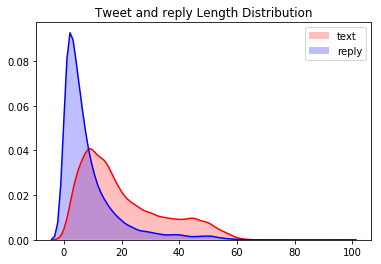

In [24]:
tweet_length = []
reply_length = []
for t in tweets:
    tweet_length.append(len(t['text_clean']))
    if t['reply'] != "":
        reply_length.append(len(t['reply_clean']))
for t in dev:
    tweet_length.append(len(t['text_clean']))
    if t['reply'] != "":
        reply_length.append(len(t['reply_clean']))
for t in test:
    tweet_length.append(len(t['text_clean']))
    if t['reply'] != "":
        reply_length.append(len(t['reply_clean']))
sns.kdeplot(tweet_length,shade=True,color='r')
sns.kdeplot(reply_length,shade=True,color='b')
plt.legend(['text','reply'])
plt.title('Tweet and reply Length Distribution')
plt.show()
hide_toggle()

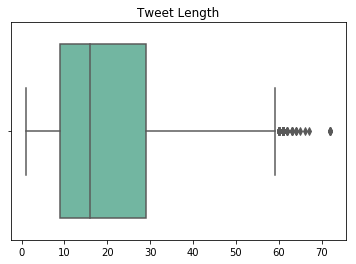

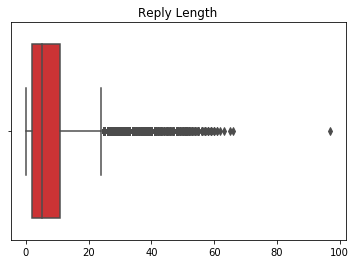

In [25]:
sns.boxplot(tweet_length,palette='Set2')
plt.title('Tweet Length')
plt.show()
sns.boxplot(reply_length,palette='Set1')
plt.title('Reply Length')
plt.show()

In [26]:
def reject_outliers(data, m=6):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### Divide the into ONLY GIF & REPLY+GIF

In [27]:
train = tweets[:28000]
val = tweets[28000:]

train_only = [t for t in train if t['reply']=='']
train_both = [t for t in train if t['reply']!='']
val_only = [t for t in val if t['reply']=='']
val_both = [t for t in val if t['reply']!='']
'''dev_only = [t for t in dev if t['reply']=='']
dev_both = [t for t in dev if t['reply']!='']'''
test_only = [t for t in test if t['reply']=='']
test_both = [t for t in test if t['reply']!='']

print("Number of tweets with RESPONSE+GIF: {} ({}%)".format(len(train_both),round(len(train_both)/len(tweets)*100,2)))
print("Number of tweets with ONLY GIF: {} ({}%)".format(len(train_only),round(len(train_only)/len(tweets)*100,2)))
print()
'''print("Number of dev with RESPONSE+GIF: {} ({}%)".format(len(dev_both),round(len(dev_both)/len(dev)*100,2)))
print("Number of dev with ONLY GIF: {} ({}%)".format(len(dev_only),round(len(dev_only)/len(dev)*100,2)))
print()'''
print("Number of test with RESPONSE+GIF: {} ({}%)".format(len(test_both),round(len(test_both)/len(test)*100,2)))
print("Number of test with ONLY GIF: {} ({}%)".format(len(test_only),round(len(test_only)/len(test)*100,2)))
hide_toggle()

Number of tweets with RESPONSE+GIF: 11169 (34.9%)
Number of tweets with ONLY GIF: 16831 (52.6%)

Number of test with RESPONSE+GIF: 1600 (40.0%)
Number of test with ONLY GIF: 2400 (60.0%)


In [28]:
display(cat_temp.style.background_gradient(cmap='Blues'))

cat = Counter()
cat_len = Counter
for t in train_only:
    cat.update(t['categories'])
    cat_len.update(len(t['categories']))
temp2 = pd.DataFrame(cat.most_common(15))
temp2.columns = ['categories_only','count']
display(temp2.style.background_gradient(cmap='Purples'))

cat = Counter()
cat_len = Counter
for t in train_both:
    cat.update(t['categories'])
    cat_len.update(len(t['categories']))
temp2 = pd.DataFrame(cat.most_common(15))
temp2.columns = ['categories_both','count']
display(temp2.style.background_gradient(cmap='Greens'))
hide_toggle()

,categories,count
0,applause,3442
1,hug,3239
2,agree,2987
3,yes,2719
4,no,2185
5,seriously,2012
6,facepalm,2001
7,smh,1881
8,sigh,1768
9,shocked,1704


,categories_only,count
0,applause,1926
1,agree,1905
2,yes,1658
3,hug,1626
4,no,1404
5,seriously,1042
6,facepalm,960
7,shocked,909
8,smh,892
9,sigh,807


,categories_both,count
0,hug,1224
1,applause,1081
2,facepalm,795
3,smh,750
4,sigh,746
5,yes,722
6,seriously,721
7,agree,710
8,shocked,590
9,omg,556


### Token distribution in each category

In [53]:
token_cat_main = {}
token_cat_reply = {}
for c in categories:
    token_cat_main[c] = Counter()
    token_cat_reply[c] = Counter()
    for t in tweets:
        if c in t['categories']:
            token_cat_main[c].update(t['text_clean'])
            token_cat_reply[c].update(t['reply_clean'])
hide_toggle()

#### Distribution in MAIN

In [54]:
token_cat_main.keys()

dict_keys(['agree', 'applause', 'awww', 'dance', 'deal_with_it', 'do_not_want', 'eww', 'eye_roll', 'facepalm', 'fist_bump', 'good_luck', 'happy_dance', 'hearts', 'high_five', 'hug', 'idk', 'kiss', 'mic_drop', 'no', 'oh_snap', 'ok', 'omg', 'oops', 'please', 'popcorn', 'scared', 'seriously', 'shocked', 'shrug', 'sigh', 'slow_clap', 'smh', 'sorry', 'thank_you', 'thumbs_down', 'thumbs_up', 'want', 'win', 'wink', 'yawn', 'yes', 'yolo', 'you_got_this'])

In [55]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
pos_mask = np.array(Image.open(r'twitter_mask.png'))

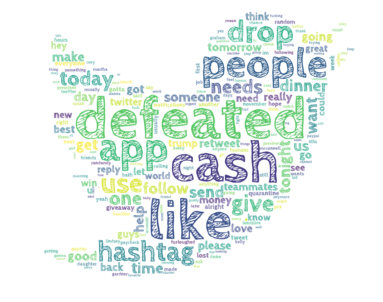

In [58]:
my_wordcloud = WordCloud(background_color="white",mask=pos_mask, width=400, height=200,font_path='CabinSketch-Bold.ttf')  
my_wordcloud.generate_from_frequencies(frequencies=Counter(token_cat_main['please']))
 
#產生圖片
image_colors = ImageColorGenerator(pos_mask);
plt.imshow(my_wordcloud,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
#顯示用

plt.savefig("Mayday_Wordcloud.png")
plt.show()

In [57]:
for cat in categories:
    print("categories: ", cat)
    temp = pd.DataFrame(token_cat_main[cat].most_common(20))
    temp.columns = ['token','count']
    display(temp.style.background_gradient(cmap='Purples'))

categories:  agree


,token,count
0,people,257
1,like,246
2,one,189
3,trump,165
4,time,154
5,get,154
6,us,145
7,day,143
8,think,139
9,need,133


categories:  applause


,token,count
0,people,299
1,like,289
2,today,243
3,get,221
4,one,212
5,day,180
6,back,179
7,got,167
8,time,166
9,good,156


categories:  awww


,token,count
0,love,105
1,like,86
2,day,62
3,people,58
4,time,53
5,today,50
6,know,50
7,want,49
8,one,49
9,get,48


categories:  dance


,token,count
0,one,67
1,good,65
2,today,59
3,like,58
4,got,55
5,us,55
6,guys,52
7,see,52
8,hi,49
9,time,48


categories:  deal_with_it


,token,count
0,people,49
1,like,39
2,trump,29
3,time,26
4,us,23
5,one,21
6,know,19
7,love,18
8,cannot,18
9,gif,17


categories:  do_not_want


,token,count
0,gif,57
1,new,41
2,please,31
3,form,31
4,answer,30
5,tracking,29
6,app,29
7,installing,28
8,like,19
9,today,19


categories:  eww


,token,count
0,gif,86
1,like,74
2,best,67
3,people,57
4,one,56
5,party,56
6,choose,55
7,republican,54
8,describes,53
9,get,46


categories:  eye_roll


,token,count
0,one,148
1,people,136
2,even,122
3,day,116
4,gif,116
5,tell,112
6,president,108
7,trump,105
8,together,103
9,quarantine,95


categories:  facepalm


,token,count
0,people,206
1,trump,193
2,get,141
3,like,136
4,one,132
5,time,120
6,president,101
7,gif,90
8,think,87
9,back,85


categories:  fist_bump


,token,count
0,like,27
1,time,22
2,follow,21
3,need,19
4,people,19
5,back,19
6,want,18
7,get,17
8,day,16
9,home,15


categories:  good_luck


,token,count
0,today,72
1,time,57
2,get,56
3,one,50
4,really,47
5,day,46
6,people,46
7,need,43
8,back,42
9,good,41


categories:  happy_dance


,token,count
0,one,64
1,see,61
2,guys,59
3,today,57
4,yes,55
5,good,53
6,new,52
7,get,52
8,😊,51
9,hi,49


categories:  hearts


,token,count
0,love,53
1,❤,48
2,like,35
3,today,34
4,people,26
5,💜,26
6,thank,24
7,one,22
8,follow,22
9,get,21


categories:  high_five


,token,count
0,like,43
1,today,38
2,day,37
3,one,35
4,time,33
5,people,31
6,us,31
7,follow,29
8,virtual,29
9,high,29


categories:  hug


,token,count
0,hug,696
1,today,448
2,need,438
3,want,311
4,like,285
5,really,278
6,day,259
7,feel,240
8,one,232
9,know,220


categories:  idk


,token,count
0,people,96
1,like,94
2,get,66
3,one,64
4,trump,62
5,time,58
6,think,57
7,gif,44
8,know,42
9,day,40


categories:  kiss


,token,count
0,👉,23
1,👈,23
2,❤,22
3,love,20
4,👍,16
5,like,13
6,one,11
7,💜,11
8,happy,10
9,thank,10


categories:  mic_drop


,token,count
0,like,14
1,said,14
2,america,13
3,trump,12
4,one,11
5,people,11
6,know,11
7,biden,10
8,need,9
9,us,9


categories:  no


,token,count
0,gif,193
1,new,189
2,please,183
3,app,143
4,answer,143
5,form,140
6,installing,135
7,tracking,135
8,think,128
9,take,115


categories:  oh_snap


,token,count
0,like,81
1,one,64
2,get,59
3,time,45
4,people,41
5,got,38
6,ass,36
7,know,35
8,really,34
9,think,34


categories:  ok


,token,count
0,like,63
1,people,60
2,one,57
3,get,52
4,back,45
5,time,42
6,day,39
7,know,36
8,today,35
9,go,34


categories:  omg


,token,count
0,like,110
1,one,91
2,get,89
3,people,86
4,trump,70
5,back,63
6,know,62
7,today,61
8,good,58
9,want,58


categories:  oops


,token,count
0,go,71
1,like,63
2,dr,62
3,get,56
4,people,56
5,doctors,48
6,oz,48
7,dependable,45
8,time,39
9,one,36


categories:  please


,token,count
0,defeated,74
1,like,63
2,cash,63
3,people,62
4,app,60
5,drop,56
6,hashtag,54
7,use,53
8,give,40
9,today,38


categories:  popcorn


,token,count
0,today,56
1,going,51
2,go,44
3,one,43
4,people,37
5,back,36
6,like,33
7,get,29
8,time,29
9,house,27


categories:  scared


,token,count
0,like,82
1,know,50
2,people,43
3,gif,42
4,get,40
5,going,40
6,today,38
7,time,36
8,think,35
9,best,35


categories:  seriously


,token,count
0,people,208
1,trump,167
2,one,144
3,get,141
4,like,137
5,time,117
6,president,109
7,back,94
8,want,91
9,day,90


categories:  shocked


,token,count
0,like,137
1,one,102
2,people,83
3,get,80
4,time,69
5,think,65
6,got,64
7,good,64
8,cannot,63
9,today,63


categories:  shrug


,token,count
0,people,86
1,like,69
2,time,61
3,get,57
4,trump,51
5,gif,48
6,think,47
7,one,44
8,good,34
9,going,33


categories:  sigh


,token,count
0,people,186
1,one,134
2,trump,121
3,get,118
4,time,117
5,like,111
6,today,90
7,gif,88
8,day,86
9,back,73


categories:  slow_clap


,token,count
0,like,123
1,people,115
2,one,82
3,get,79
4,back,76
5,today,74
6,day,71
7,got,65
8,us,63
9,need,62


categories:  smh


,token,count
0,people,189
1,trump,148
2,one,148
3,like,138
4,get,129
5,time,127
6,president,85
7,new,84
8,today,77
9,gif,76


categories:  sorry


,token,count
0,dr,56
1,go,52
2,doctors,46
3,oz,44
4,dependable,43
5,one,25
6,people,20
7,like,18
8,going,17
9,time,17


categories:  thank_you


,token,count
0,happy,92
1,people,90
2,follow,68
3,love,66
4,like,64
5,birthday,61
6,today,55
7,thank,52
8,get,49
9,time,45


categories:  thumbs_down


,token,count
0,gif,45
1,best,32
2,party,31
3,republican,30
4,choose,29
5,describes,29
6,people,19
7,like,17
8,new,17
9,please,14


categories:  thumbs_up


,token,count
0,dr,203
1,go,194
2,doctors,179
3,oz,179
4,dependable,175
5,like,43
6,today,40
7,people,38
8,follow,35
9,good,34


categories:  want


,token,count
0,dr,36
1,need,28
2,go,25
3,want,22
4,oz,22
5,hug,20
6,doctors,20
7,dependable,19
8,like,16
9,defeated,16


categories:  win


,token,count
0,today,41
1,one,34
2,good,33
3,day,28
4,get,26
5,trump,25
6,like,24
7,people,23
8,time,22
9,back,21


categories:  wink


,token,count
0,like,46
1,people,38
2,get,35
3,one,29
4,day,28
5,make,27
6,love,24
7,want,21
8,today,20
9,back,19


categories:  yawn


,token,count
0,👏,65
1,gif,52
2,people,44
3,one,41
4,even,33
5,day,31
6,tell,29
7,like,29
8,together,28
9,today,28


categories:  yes


,token,count
0,get,173
1,like,170
2,people,160
3,think,143
4,one,138
5,trump,135
6,today,134
7,time,134
8,day,124
9,back,116


categories:  yolo


,token,count
0,people,18
1,like,16
2,cannot,12
3,today,9
4,tell,9
5,let,9
6,please,9
7,still,8
8,know,8
9,one,8


categories:  you_got_this


,token,count
0,today,91
1,need,70
2,day,68
3,👏,64
4,get,63
5,time,63
6,hug,58
7,really,57
8,want,57
9,good,54


#### Distribution in REPLY

In [34]:
for cat in categories:
    print("categories: ", cat)
    temp = pd.DataFrame(token_cat_reply[cat].most_common(20))
    temp.columns = ['token','count']
    display(temp.style.background_gradient(cmap='Reds'))

categories:  agree


,token,count
0,i,183
1,you,160
2,the,147
3,to,123
4,is,118
5,it,105
6,and,99
7,a,94
8,that,79
9,of,78


categories:  applause


,token,count
0,you,290
1,i,192
2,the,188
3,is,186
4,a,158
5,to,157
6,it,130
7,and,117
8,that,106
9,👏,104


categories:  awww


,token,count
0,you,151
1,i,139
2,a,67
3,and,59
4,the,58
5,to,56
6,is,52
7,it,51
8,me,46
9,so,46


categories:  dance


,token,count
0,i,158
1,you,88
2,the,87
3,a,66
4,to,64
5,and,58
6,is,56
7,me,54
8,am,51
9,it,50


categories:  deal_with_it


,token,count
0,the,83
1,i,68
2,to,55
3,you,49
4,a,46
5,is,42
6,not,39
7,and,37
8,it,36
9,that,30


categories:  do_not_want


,token,count
0,the,24
1,to,17
2,is,16
3,you,14
4,no,14
5,of,13
6,not,13
7,in,12
8,a,12
9,it,12


categories:  eww


,token,count
0,the,76
1,i,76
2,you,70
3,to,63
4,is,63
5,it,51
6,a,49
7,not,47
8,that,42
9,and,38


categories:  eye_roll


,token,count
0,the,182
1,you,136
2,i,126
3,is,126
4,to,116
5,and,100
6,not,97
7,a,96
8,it,71
9,that,69


categories:  facepalm


,token,count
0,the,328
1,i,261
2,is,246
3,you,228
4,to,200
5,a,177
6,and,167
7,it,151
8,not,148
9,that,135


categories:  fist_bump


,token,count
0,i,39
1,you,37
2,to,35
3,the,33
4,is,28
5,and,25
6,a,23
7,it,19
8,in,17
9,of,17


categories:  good_luck


,token,count
0,you,115
1,it,61
2,the,58
3,to,56
4,i,56
5,and,47
6,for,43
7,this,36
8,a,36
9,in,32


categories:  happy_dance


,token,count
0,i,140
1,the,84
2,you,80
3,is,68
4,to,65
5,a,61
6,and,57
7,it,55
8,am,42
9,my,37


categories:  hearts


,token,count
0,you,109
1,i,60
2,❤,39
3,love,37
4,to,34
5,and,31
6,for,28
7,are,27
8,of,26
9,thank,24


categories:  high_five


,token,count
0,you,52
1,the,50
2,i,46
3,to,37
4,it,30
5,a,30
6,is,28
7,of,21
8,that,20
9,and,19


categories:  hug


,token,count
0,you,709
1,i,493
2,to,273
3,and,253
4,❤,249
5,a,217
6,are,189
7,am,172
8,the,171
9,for,163


categories:  idk


,token,count
0,i,225
1,the,181
2,is,139
3,you,131
4,to,114
5,not,110
6,a,103
7,and,94
8,it,89
9,that,84


categories:  kiss


,token,count
0,you,62
1,i,39
2,love,24
3,and,20
4,the,14
5,❤,14
6,is,13
7,for,13
8,a,12
9,are,12


categories:  mic_drop


,token,count
0,you,29
1,the,28
2,is,19
3,and,18
4,i,17
5,your,16
6,it,15
7,that,15
8,not,13
9,to,13


categories:  no


,token,count
0,i,146
1,the,102
2,to,101
3,no,98
4,not,96
5,is,95
6,you,82
7,a,76
8,it,69
9,that,67


categories:  oh_snap


,token,count
0,i,84
1,you,67
2,the,49
3,is,47
4,a,45
5,to,43
6,and,36
7,that,32
8,it,30
9,not,30


categories:  ok


,token,count
0,i,89
1,the,82
2,you,75
3,to,60
4,a,59
5,is,47
6,and,46
7,of,44
8,it,42
9,not,41


categories:  omg


,token,count
0,i,157
1,you,131
2,the,124
3,is,111
4,a,98
5,to,84
6,and,77
7,it,69
8,not,60
9,that,60


categories:  oops


,token,count
0,i,165
1,the,108
2,you,86
3,to,83
4,is,81
5,and,76
6,a,74
7,not,65
8,it,56
9,that,56


categories:  please


,token,count
0,i,138
1,you,75
2,please,69
3,to,65
4,me,58
5,and,58
6,the,56
7,a,56
8,my,55
9,is,43


categories:  popcorn


,token,count
0,i,73
1,the,70
2,to,47
3,for,45
4,is,42
5,this,41
6,it,36
7,a,34
8,am,32
9,me,29


categories:  scared


,token,count
0,i,118
1,the,87
2,you,74
3,to,72
4,a,67
5,is,53
6,and,52
7,it,51
8,me,49
9,my,48


categories:  seriously


,token,count
0,the,277
1,you,237
2,i,237
3,is,207
4,to,190
5,a,162
6,and,159
7,not,148
8,it,134
9,that,115


categories:  shocked


,token,count
0,i,176
1,you,135
2,the,125
3,a,105
4,is,94
5,that,83
6,to,81
7,not,72
8,and,69
9,it,64


categories:  shrug


,token,count
0,i,245
1,the,167
2,is,135
3,you,124
4,a,123
5,and,116
6,to,113
7,not,113
8,it,93
9,that,79


categories:  sigh


,token,count
0,the,279
1,i,272
2,you,207
3,is,192
4,to,188
5,a,167
6,and,151
7,not,141
8,it,133
9,that,119


categories:  slow_clap


,token,count
0,you,109
1,i,104
2,is,71
3,to,71
4,the,67
5,it,59
6,a,49
7,this,46
8,👏,44
9,for,39


categories:  smh


,token,count
0,the,280
1,you,244
2,i,224
3,is,211
4,to,197
5,and,165
6,not,162
7,a,160
8,it,138
9,that,122


categories:  sorry


,token,count
0,i,74
1,the,50
2,is,38
3,to,35
4,a,34
5,you,32
6,it,31
7,not,30
8,and,24
9,that,21


categories:  thank_you


,token,count
0,you,207
1,thank,112
2,i,95
3,for,82
4,and,65
5,the,65
6,to,60
7,so,49
8,this,39
9,a,38


categories:  thumbs_down


,token,count
0,the,20
1,you,17
2,a,16
3,and,15
4,is,15
5,to,13
6,i,13
7,not,13
8,in,10
9,it,9


categories:  thumbs_up


,token,count
0,you,67
1,i,62
2,the,61
3,to,49
4,is,44
5,a,44
6,and,42
7,of,40
8,that,27
9,it,26


categories:  want


,token,count
0,i,32
1,it,18
2,and,14
3,to,14
4,you,14
5,am,13
6,me,12
7,the,12
8,a,11
9,is,11


categories:  win


,token,count
0,i,48
1,the,33
2,a,32
3,to,32
4,and,31
5,you,31
6,that,19
7,of,18
8,it,17
9,yes,16


categories:  wink


,token,count
0,i,74
1,you,66
2,a,50
3,the,49
4,to,43
5,is,36
6,it,27
7,in,24
8,and,24
9,are,24


categories:  yawn


,token,count
0,the,65
1,i,58
2,you,45
3,is,42
4,to,42
5,a,31
6,and,31
7,it,26
8,not,25
9,of,25


categories:  yes


,token,count
0,i,233
1,you,156
2,the,142
3,to,119
4,is,100
5,and,93
6,yes,90
7,it,88
8,a,88
9,that,76


categories:  yolo


,token,count
0,the,42
1,i,39
2,a,21
3,is,21
4,you,17
5,to,17
6,it,17
7,not,16
8,and,16
9,am,14


categories:  you_got_this


,token,count
0,you,151
1,i,85
2,to,67
3,and,58
4,it,57
5,the,52
6,a,51
7,this,42
8,for,39
9,is,38


## Test

In [35]:
cat1 = Counter()
cat2 = Counter()
for t in train:
    if t['reply']=='':
        cat2.update(t['categories'])
    else:
        cat1.update(t['categories'])

In [36]:
both = [x[0] for x in cat1.most_common(6)]
only = [x[0] for x in cat2.most_common(6)]

In [37]:
temp_cat = []
for t in tweets:
    if len(t['categories'])>1:
        temp_cat.append(t['categories'])
temp_cat

[['shocked', 'omg'],
 ['scared', 'oops'],
 ['agree', 'yes'],
 ['seriously', 'agree', 'yes'],
 ['seriously', 'agree', 'yes'],
 ['seriously', 'facepalm'],
 ['seriously', 'smh', 'sigh', 'idk', 'shrug', 'facepalm'],
 ['eye_roll', 'facepalm', 'smh'],
 ['slow_clap', 'applause', 'yes'],
 ['oh_snap', 'mic_drop'],
 ['shrug', 'idk'],
 ['sigh', 'facepalm'],
 ['happy_dance', 'yes'],
 ['slow_clap', 'applause'],
 ['slow_clap', 'applause'],
 ['smh', 'facepalm'],
 ['hug', 'you_got_this'],
 ['agree', 'yes'],
 ['oh_snap', 'shocked', 'omg'],
 ['slow_clap', 'applause'],
 ['smh', 'facepalm', 'sigh'],
 ['slow_clap', 'applause'],
 ['agree', 'yes'],
 ['eye_roll', 'yawn'],
 ['oh_snap', 'shocked', 'scared'],
 ['good_luck', 'you_got_this'],
 ['scared', 'shocked', 'omg'],
 ['hug', 'you_got_this'],
 ['agree', 'yes'],
 ['scared', 'shocked', 'omg'],
 ['slow_clap', 'applause', 'yes'],
 ['oh_snap', 'shocked', 'omg'],
 ['dance', 'happy_dance'],
 ['shrug', 'idk'],
 ['agree', 'yes'],
 ['slow_clap', 'applause', 'yes'],
 [

In [38]:
for c in categories:    
    cat_together = Counter()
    for t in temp_cat:
        if c in t:
            cat_together.update(t)
    print(c)
    print(cat_together.most_common()[1:])

agree
[('yes', 1089), ('seriously', 151), ('thumbs_up', 89), ('ok', 71), ('applause', 36), ('win', 22), ('high_five', 22), ('good_luck', 22), ('fist_bump', 9), ('you_got_this', 9)]
applause
[('slow_clap', 1148), ('yes', 183), ('thumbs_up', 93), ('dance', 61), ('happy_dance', 61), ('agree', 36)]
awww
[('oops', 98), ('yes', 98), ('hearts', 58), ('please', 34), ('wink', 29)]
dance
[('happy_dance', 369), ('applause', 61), ('win', 36)]
deal_with_it
[('yolo', 110), ('shrug', 102), ('sorry', 55), ('oops', 55), ('idk', 55), ('ok', 38), ('mic_drop', 14)]
do_not_want
[('no', 162), ('smh', 9)]
eww
[('omg', 241), ('seriously', 175), ('idk', 175), ('facepalm', 175), ('scared', 66), ('shocked', 66), ('smh', 44), ('want', 7)]
eye_roll
[('sigh', 358), ('seriously', 322), ('smh', 314), ('yawn', 194), ('facepalm', 145), ('ok', 47), ('yes', 47), ('please', 15)]
facepalm
[('seriously', 1197), ('sigh', 1065), ('smh', 1001), ('omg', 423), ('idk', 378), ('shrug', 203), ('eww', 175), ('no', 159), ('eye_roll',

## DeepLearning
### Word Embedding

In [16]:
glove_dir = r'glove.twitter.27B.100d.txt'

embedding_index={}
f = open(glove_dir, encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()
len(embedding_index)

1193514

In [17]:
emoji_dir = r'emoji_embeddings_100d.txt'

f = open(emoji_dir, encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word not in embedding_index:
        embedding_index[word] = coefs
f.close()
len(embedding_index)

1195095

In [76]:
all_token = Counter()
for t in tweets:
    all_token.update(t['text_clean'])
    all_token.update(t['reply_clean'])
for t in dev:
    all_token.update(t['text_clean'])
    all_token.update(t['reply_clean'])
for t in test:
    all_token.update(t['text_clean'])
    all_token.update(t['reply_clean'])

weird = {}
for i in all_token:
    if i not in embedding_index:
        weird[i] = all_token[i]

weird = Counter(weird)

print("ALL: ",len(all_token))
print("Special: ",len(weird))

temp = pd.DataFrame(weird.most_common(30))
temp.columns = ['special token','count']
display(temp.style.background_gradient(cmap='Purples'))
temp = pd.DataFrame(weird.most_common()[:-20-1:-1])
temp.columns = ['special token','count']
display(temp.style.background_gradient(cmap='Purples'))

ALL:  35270
Special:  6094


,special token,count
0,covid,804
1,:),184
2,trump's,182
3,ventilators,172
4,:(,158
5,fortnite,67
6,fauci,55
7,onlyfans,54
8,valorant,48
9,:/,43


,special token,count
0,skuddies,1
1,svgs,1
2,jpgs,1
3,idlephobic,1
4,laughingly,1
5,appreciably,1
6,haaaaaaaaaa,1
7,smoaking,1
8,bedroom-eboy,1
9,bchez,1


#### Mapping special words

In [77]:
'''
Deal with special words for embedding such as
covid  (806) → coronavirus
'''
special = {
    'covid':'coronavirus',
    "trump's":'trump',
    "ventilators":"ventilator",
    "virologist":'virology',
    'fauci':'physician',
    "onlyfans":"app",
    "fortnite":"game",
    "valorant":"game",
    "jeudy":"athlete",
    "ruggs":"athlete",
    "tagovailoa":"athlete",
    "rashford":"athlete",
    "birx":"doctor",
    "blaqbonez":"rapper",
    'mcsally':"politician",
    "intubated":"intubation",
    "hydroxychloroquine":"medication",
    "today's":"today",
    "pubg":"game",
    "government's":'government',
    "man's":'man',
    "someone's":'someone',
    "country's":'country',
    "everyone's":'everyone',
    "people's":'people',
    "club's":'club',
    "china's":'china',
    "america's":'america',
    "world's":'world',
    "life's":'life',
    "earth's":'earth',
    "mom's":'mom',
    '<3':'❤',
    ':)':"🙂",
    ":(":"😞",
    "):":"😞",
    ":/":"😕",
    "pre-covid":'coronavirus',
    "strategise":"strategies",
    'stratagy':'strategy',
    "strategiser":"strategy",
    "stratagised":"strategy",
    'ohhhh':"ohhh",
    'yesssss':"yes",
    'youuu':'you',
    'sirrr':'sir',
    'ohhhhh':'ohhh',
    'youuuu':'you',
    'lmaooooo':'lamo',
    'guysss':'guys',
    'meeeee':'me',
    'yessss':'yes',
    'lieeeeeee':'lie',
    'youuuuu':'you',
    'yesssssss':'yes',
    'lollll':'lol',
    'plzzzz':'plz',
    'enddddddd':'end',
}

In [78]:
for t in tweets:
    for idx,token in enumerate(t['text_clean']):
        if token in special:
            t['text_clean'][idx] = special[token]
    for idx,token in enumerate(t['reply_clean']):
        if token in special:
            t['reply_clean'][idx] = special[token]
    t['text_clean'] = [c for c in t['text_clean'] if c not in weird]
    t['reply_clean'] = [c for c in t['reply_clean'] if c not in weird]
for t in dev:
    for idx,token in enumerate(t['text_clean']):
        if token in special:
            t['text_clean'][idx] = special[token]
    for idx,token in enumerate(t['reply_clean']):
        if token in special:
            t['reply_clean'][idx] = special[token]
    t['text_clean'] = [c for c in t['text_clean'] if c not in weird]
    t['reply_clean'] = [c for c in t['reply_clean'] if c not in weird]
for t in test:
    for idx,token in enumerate(t['text_clean']):
        if token in special:
            t['text_clean'][idx] = special[token]
    for idx,token in enumerate(t['reply_clean']):
        if token in special:
            t['reply_clean'][idx] = special[token]
    t['text_clean'] = [c for c in t['text_clean'] if c not in weird]
    t['reply_clean'] = [c for c in t['reply_clean'] if c not in weird]

all_token = Counter()
for t in tweets:
    all_token.update(t['text_clean'])
    all_token.update(t['reply_clean'])
for t in dev:
    all_token.update(t['text_clean'])
    all_token.update(t['reply_clean'])
for t in test:
    all_token.update(t['text_clean'])
    all_token.update(t['reply_clean'])

weird = {}
for i in all_token:
    if i not in embedding_index:
        weird[i] = all_token[i]

weird = Counter(weird)

print("ALL: ",len(all_token))
print("Special: ",len(weird))
hide_toggle()

ALL:  29176
Special:  0


In [79]:
embedding_dim = 100
max_words = len(all_token)
token_index = {}

embedding_mtx = np.zeros((max_words+1, embedding_dim))
for i, token in enumerate(all_token):
    token_index[token] = i+1
    embedding_vector = embedding_index.get(token)
    if embedding_vector is not None:
        embedding_mtx[i+1] = embedding_vector

In [81]:
embedding_mtx.shape

(29177, 100)

### Preparing & splitting training / validation sets

In [83]:
def word2vec(corpus):
    res = []
    for tweet in corpus:
        vec = []
        for token in tweet:
            vec.append(token_index[token])
        res.append(vec)
    return np.array(res)

In [84]:
def cat2vec(cat):
    res = []
    for tweet in cat:
        temp = np.zeros(43)
        for c in tweet:
            temp[cat_index[c]] = 1
        res.append(temp)
    return np.array(res)

In [85]:
def stratified(corpus,p=0.2):
    train = []
    val = []
    idx = {}
    for i, tweet in enumerate(corpus):
        cats = tweet['categories']
        for cat in cats:
            if cat in idx:
                idx[cat].append(i)
            else:
                idx[cat] = [i]
    for cat in idx:
        N = int(len(idx[cat])*p)
        val.extend(idx[cat][:N])
        train.extend(idx[cat][N:])
    return list(set(train)), list(set(val))

In [86]:
cat_index = {}
for idx,c in enumerate(categories):
    cat_index[c]=idx

In [119]:
idx_train, idx_val = stratified(tweets,0)

train = np.array(tweets)[idx_train]
val = np.array(tweets)[idx_val]

train_only = [t for t in train if t['reply']=='' and t['text_clean']!=[]]
train_both = [t for t in train if t['reply_clean']!=[]]
val_only = [t for t in val if t['reply']=='']
val_both = [t for t in val if t['reply']!='']
dev_only = [t for t in dev if t['reply']=='']
dev_both = [t for t in dev if t['reply']!='']
test_only = [t for t in test if t['reply']=='']
test_both = [t for t in test if t['reply']!='']
print("Length of valiation set: ",len(val))

maxlen_text = 43
maxlen_reply = 47

# Training
train_x = [t['text_clean'] for t in train if t['text_clean']!=[]]
train_y = [t['categories'] for t in train if t['text_clean']!=[]]
train_only_x = [t['text_clean'] for t in train_only]
train_only_y = [t['categories'] for t in train_only]
train_both_x = [t['text_clean'] for t in train_both]
train_reply_x = [t['reply_clean'] for t in train_both]
train_both_y = [t['categories'] for t in train_both]

train_x = pad_sequences(word2vec(train_x),maxlen_text)
train_y = cat2vec(train_y)
train_only_x = pad_sequences(word2vec(train_only_x),maxlen_text)
train_only_y = cat2vec(train_only_y)
train_both_x = pad_sequences(word2vec(train_both_x),maxlen_text)
train_reply_x = pad_sequences(word2vec(train_reply_x),maxlen_reply)
train_both_y = cat2vec(train_both_y)

# Validation
val_x = [t['text_clean'] for t in val]
val_y = [t['categories'] for t in val]
val_only_x = [t['text_clean'] for t in val_only]
val_only_y = [t['categories'] for t in val_only]
val_both_x = [t['text_clean'] for t in val_both]
val_reply_x = [t['reply_clean'] for t in val_both]
val_both_y = [t['categories'] for t in val_both]

val_x = pad_sequences(word2vec(val_x),maxlen_text)
val_y = cat2vec(val_y)
val_only_x = pad_sequences(word2vec(val_only_x),maxlen_text)
val_only_y = cat2vec(val_only_y)
val_both_x = pad_sequences(word2vec(val_both_x),maxlen_text)
val_reply_x = pad_sequences(word2vec(val_reply_x),maxlen_reply)
val_both_y = cat2vec(val_both_y)

# Dev
dev_x = [t['text_clean'] for t in dev]
dev_only_x = [t['text_clean'] for t in dev_only]
dev_both_x = [t['text_clean'] for t in dev_both]
dev_reply_x = [t['reply_clean'] for t in dev_both]

dev_x = pad_sequences(word2vec(dev_x),maxlen_text)
dev_only_x = pad_sequences(word2vec(dev_only_x),maxlen_text)
dev_both_x = pad_sequences(word2vec(dev_both_x),maxlen_text)
dev_reply_x = pad_sequences(word2vec(dev_reply_x),maxlen_reply)

# Testing
test_x = [t['text_clean'] for t in test]
test_only_x = [t['text_clean'] for t in test_only]
test_both_x = [t['text_clean'] for t in test_both]
test_reply_x = [t['reply_clean'] for t in test_both]

test_x = pad_sequences(word2vec(test_x),maxlen_text)
test_only_x = pad_sequences(word2vec(test_only_x),maxlen_text)
test_both_x = pad_sequences(word2vec(test_both_x),maxlen_text)
test_reply_x = pad_sequences(word2vec(test_reply_x),maxlen_reply)

Length of valiation set:  0


In [130]:
idx_train, idx_val = stratified(tweets,0)

train = np.array(tweets)[idx_train]
val = np.array(tweets)[idx_val]

maxlen_combine = 123

# Training
train_combine_x = [t['text_clean']+t['reply_clean'] for t in train]
train_combine_x = pad_sequences(word2vec(train_combine_x),maxlen_combine)
train_combine_y = [t['categories'] for t in train]
train_combine_y = cat2vec(train_combine_y)

dev_combine_x = [t['text_clean']+t['reply_clean'] for t in dev]
dev_combine_x = pad_sequences(word2vec(dev_combine_x),maxlen_combine)

test_combine_x = [t['text_clean']+t['reply_clean'] for t in test]
test_combine_x = pad_sequences(word2vec(test_combine_x),maxlen_combine)

In [27]:
train_reply_x

array([[   0,    0,    0, ...,    0,   10,   10],
       [   0,    0,    0, ...,   67,   68,   69],
       [   0,    0,    0, ...,  111,  112,  113],
       ...,
       [   0,    0,    0, ..., 1058,   21, 1943],
       [   0,    0,    0, ...,  503,  261, 3091],
       [   0,    0,    0, ...,  161,  224,  698]], dtype=int32)

In [28]:
print(embedding_index["nlp"])

[-0.12459   -0.37272   -0.26352   -0.37745    0.057773  -0.19055
  0.58908   -0.49284    0.34724   -0.52574   -0.26923    0.21072
 -0.68248    0.35767   -0.35779   -0.77829    0.0046297  0.72781
 -0.26878   -0.027378  -0.046434   0.17313    0.1069     0.29224
 -0.42782    0.49221   -0.20114    1.3324    -0.59951    0.72042
 -0.074865   0.033693   0.4407    -0.029863  -0.057603   0.062718
  0.77556   -0.26519   -0.32445   -0.48258    0.082125   0.31221
 -0.24614    0.83754    0.44058    0.07511   -1.4878     0.1855
  0.11038   -0.38312    1.2688    -0.16575   -1.0618    -0.30493
  0.30455   -0.45807    0.45474   -0.71415   -0.26719    0.63431
  0.24073   -0.39495    0.54834   -0.086269  -0.62147    0.46611
 -0.37634    0.14207    0.32901    0.70929   -0.43644    0.71118
 -0.19006   -0.067619   0.45769    0.28946    0.2198     0.15163
  0.01201   -1.3974    -0.043507   0.38988    0.47912    0.35145
 -0.61612    0.36085   -0.040213   0.02948    0.19861    0.043065
 -0.50664   -0.65271    

### Modeling

In [116]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Embedding, Dense

In [117]:
def modeling(x,y,maxlen):
    model = Sequential()
    model.add(Embedding(max_words+1, embedding_dim))
    model.add(Dropout(0.5))
    model.add(LSTM(128,dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
    model.add(LSTM(256,dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(43, activation='sigmoid'))
    
    model.layers[0].set_weights([embedding_mtx])
    model.layers[0].trainable = False
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=["top_k_categorical_accuracy"])
    
    history = model.fit(x,y,
                        epochs=20,
                        batch_size=32)
    return model

In [ ]:
model_text = modeling(train_x, train_y, maxlen_text)
model_reply = modeling(train_reply_x, train_both_y, maxlen_reply)

In [132]:
model_combine = modeling(train_combine_x, train_combine_y, maxlen_combine)

Epoch 1/20
32000/32000 [==============================] - 357s 11ms/step - loss: 0.1400 - top_k_categorical_accuracy: 0.3566
Epoch 2/20
32000/32000 [==============================] - 351s 11ms/step - loss: 0.1330 - top_k_categorical_accuracy: 0.3989
Epoch 3/20
32000/32000 [==============================] - 352s 11ms/step - loss: 0.1302 - top_k_categorical_accuracy: 0.4112
Epoch 4/20
32000/32000 [==============================] - 351s 11ms/step - loss: 0.1291 - top_k_categorical_accuracy: 0.4178
Epoch 5/20
32000/32000 [==============================] - 351s 11ms/step - loss: 0.1284 - top_k_categorical_accuracy: 0.4277
Epoch 6/20
32000/32000 [==============================] - 350s 11ms/step - loss: 0.1279 - top_k_categorical_accuracy: 0.4345
Epoch 7/20
32000/32000 [==============================] - 356s 11ms/step - loss: 0.1275 - top_k_categorical_accuracy: 0.4369
Epoch 8/20
32000/32000 [==============================] - 361s 11ms/step - loss: 0.1270 - top_k_categorical_accuracy: 0.4415


In [133]:
model_text.save('model_text.h5')
model_reply.save('model_reply.h5')
model_reply.save('model_combine.h5')

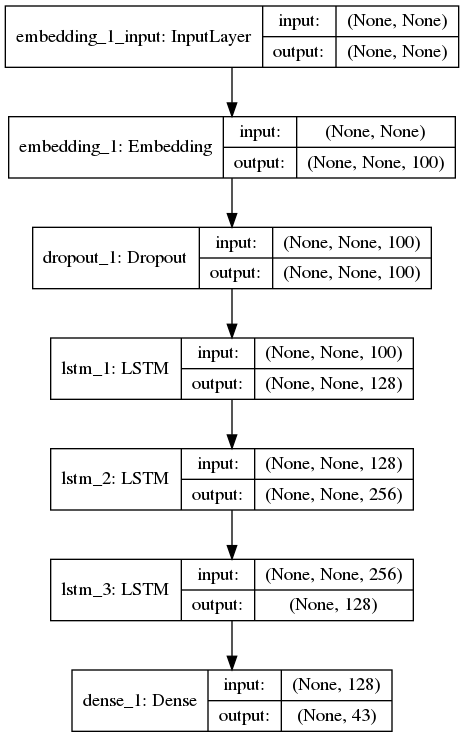

In [97]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

### Validate

In [106]:
def MAR(pred, y):
    score = []
    for idx,ans in enumerate(pred):
        N = sum(y[idx])
        temp = 0
        for p in ans:
            if y[idx][p]:
                temp+=1
        temp/=N
        score.append(temp)
    return np.mean(score)

In [128]:
'''
LSTM, w/o feature engineering, duplicate
0.4644986449864499 0.3882828282828283 0.4165656565656566
0.4016161616161616
0.43934565163833456

LSTM, w/ FE, duplicate
0.46747967479674796 0.37333333333333335 0.4105050505050505
0.3878787878787879
0.44468982508006893

4LSTM w/ FE, no duplicate
0.4923348566680515 0.3843691148775894 0.433458882611425
0.38209876543209875
0.4687844670454009

4LSTM w/ FE, no duplicate, straitfied
0.502201826956222 0.38901456058242334 0.4133840353614144
0.4044396775871034
0.4666747103182989

4LSTM(200) w/ FE, no duplicate, straitfied, rmv all weird
0.4971604619096863 0.4137870514820593 0.4172581903276131
0.38111024440977637
0.465199553276857
'''

results_only = model_text2.predict(val_only_x)
results_only = [np.argsort(res)[::-1][:6] for res in results_only]
score_only = MAR(results_only, val_only_y)

results_both = model_both2.predict(val_both_x)
results_reply = model_reply2.predict(val_reply_x)
results_combine = [results_both[i]*0.5+results_reply*0.5 for i in range(len(results_both))][0]

results_both = [np.argsort(res)[::-1][:6] for res in results_both]
results_reply = [np.argsort(res)[::-1][:6] for res in results_reply]
results_combine = [np.argsort(res)[::-1][:6] for res in results_combine]

score_both = MAR(results_both, val_both_y)
score_reply = MAR(results_reply, val_both_y)
score_combine = MAR(results_combine, val_both_y)

print(score_only, score_both, score_reply)
print(score_combine)
print(0.6*score_only+0.4*score_reply)

0.5078852119958635 0.40845033801352054 0.43099973998959956
0.40438117524700984
0.4771310231933579


### Final

In [122]:
def output(phase, dirc):
    for i in phase:
        with open(dirc+'dev.json', 'a', encoding='utf-8') as f:
            json.dump(i, f, ensure_ascii=False)
            f.write('\n')

In [123]:
def decode_cat(res):
    ans = []
    for r in res:
        temp = [categories[i] for i in r]
        ans.append(temp)
    return ans

In [124]:
results_only = model_text.predict(dev_x)
results_both = model_text.predict(dev_both_x)
results_reply = model_reply.predict(dev_reply_x)
results_combine = [results_both[i]*1+results_reply*0 for i in range(len(results_both))][0]

results_only = [np.argsort(res)[::-1][:6] for res in results_only]
results_reply = [np.argsort(res)[::-1][:6] for res in results_reply]
results_combine = [np.argsort(res)[::-1][:6] for res in results_combine]

results_only = decode_cat(results_only)
results_reply = decode_cat(results_reply)
results_combine = decode_cat(results_combine)

In [134]:
results = model_combine.predict(dev_x)
results = [np.argsort(res)[::-1][:6] for res in results]
results = decode_cat(results)

In [135]:
for idx,t in enumerate(dev):
    t['categories'] = results[idx]

In [125]:
for idx,t in enumerate(dev):
    t['categories'] = results_only[idx]

idx = 0
for t in dev:
    if t['reply']!='':
        t['categories']=results_reply[idx]
        idx+=1
idx == len(dev_both)

True

In [144]:
## Final organize
most_six = ['applause', 'hug', 'agree', 'yes', 'no', 'seriously']
for d in dev:
    if d['text_clean']==[]:
        d['categories'] = most_six
        
for idx,d in enumerate(dev):
    if d['reply']!='' and d['reply_clean']==[]:
        d['categories']=results_only[idx]

In [140]:
dev2 = []
for line in open('dev_unlabeled.json','r'):
    dev2.append(json.loads(line))
for idx,d in enumerate(dev):
    dev2[idx]['categories']=d['categories']

In [141]:
output(dev2, '')